In [1]:
TRAIN_ALL = False
TRAIN_BEST = True

In [2]:
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.utils import class_weight

from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Flatten, MaxPooling1D, CuDNNLSTM
from keras.models import Sequential, load_model, model_from_json
from keras.utils import plot_model, to_categorical

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import itertools
import keras
import time
import os

Using TensorFlow backend.


## Utilities

In [15]:
def plot_confusion_matrix(cm, class_labels, model_name, cmap=plt.cm.Blues):
    diagram_dir = os.path.join(os.getcwd(), "images")
    if not os.path.exists(diagram_dir):
        os.makedirs(diagram_dir)
    
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    
    # create the figure
    fig = plt.figure()
    fig.set_size_inches(18,15)
    
    # labels
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    # tick marks
    class_count = len(class_labels)
    tick_marks = np.arange(class_count + 1)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # normalization
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, 6)
    
    # numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
    
    # color bar
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    # save and show
    np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
    plt.savefig(os.path.join(diagram_dir, model_name + "_confusion_matrix.png"), dpi=100)
    pd.DataFrame(cm).to_csv(os.path.join(stats_dir, model_name + "_confusion_matrix.txt"), header=None, index=None)
    plt.show(block=False)
    

def graph_history(history, model_name, validation_data=False):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(history.history["acc"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_acc"], linestyle="--", color="grey")
        plt.legend(["Tr. Acc", "Val. Acc"])
    
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_accuracy.png"), dpi=400)
    plt.show()
 
    # summarize history for loss
    fig = plt.figure()
    plt.plot(history.history["loss"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_loss"], linestyle="--", color="grey")
        plt.legend(["Tr. Loss", "Val. Loss"])
    
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_loss.png"), dpi=400)
    plt.show()

    
def save_model(model, model_name):
    directory = os.path.join(os.getcwd(), "models")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # save architecture
    with open(os.path.join(directory, model_name + ".json"), "w+") as f:
        f.write(model.to_json())
    
    # save weights
    model.save_weights(os.path.join(directory, model_name + "_weights.h5"))

def load_model(model_name):
    directory = os.path.join(os.getcwd(), "models")

    if os.path.exists(directory):
        # load the architecture
        json_file = open(os.path.join(directory, model_name + ".json"))
        model = model_from_json(json_file.read())
        model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        json_file.close()

        # load the weights and return the model
        model.load_weights(os.path.join(directory, model_name + "_weights.h5"))
        return model

## Load data

In [4]:
# how long does this take?
start = time.time()

filename = "../snapshots/snapshots.csv"

# read the file with all dtypes
col_names = pd.read_csv(filename, nrows=0).columns
types_dict = {"Vehicle": int, "Capture": int, "ArbID": object, "Data": object}
types_dict.update({col: int for col in col_names if col not in types_dict})
df = pd.read_csv(filename, dtype=types_dict)

display(df.sample(frac=0.0001).head(5))
print("Elapsed time: {:.2f} seconds".format(time.time() - start))

Vehicle  Capture ArbID  Data 1  Data 2  Data 3  Data 4  Data 5  \
253671        7       31   604       1     245       6      77       4   
164395        4       20   516     228       0     125      96       0   
24968         3        5   372       0       0       0     187       9   
42967         3        7   505       0       0       0       0       0   
104488        3       13   505       0       0       0       0       0   

        Data 6  Data 7  ...  Data 1015  Data 1016  Data 1017  Data 1018  \
253671      24     130  ...        130         92          1        243   
164395     243       0  ...          0          0        224          0   
24968        0       0  ...          0          0          0          0   
42967        0       0  ...          0          0          0          0   
104488       0       0  ...          0          0          0          0   

        Data 1019  Data 1020  Data 1021  Data 1022  Data 1023  Data 1024  
253671          6         77          4         24        130         92  
164395        125         96          0        244          0          0  
24968           0        187          8          0          0          0  
42967           0          0          0          0          0          0  
104488          0          0          0          0          0          0  

[5 rows x 1027 columns]

Elapsed time: 28.98 seconds


In [5]:
# relabel the vehicles
new_labels = {v: i for i, v in enumerate(df["Vehicle"].unique())}
old_labels = {i: v for i, v in enumerate(df["Vehicle"].unique())}

df["Vehicle"] = df["Vehicle"].map(new_labels)
display(df.sample(frac=0.0001).head(5))

Vehicle  Capture ArbID  Data 1  Data 2  Data 3  Data 4  Data 5  \
48697         2        8     2     255       0       7     211     231   
144416        2       17   374      11     112       0       0      13   
33960         2        6   372       0       0       0     187      11   
195950        4       21   454      52     157      52     157       0   
160651        3       20    16       9      69     139      18       8   

        Data 6  Data 7  ...  Data 1015  Data 1016  Data 1017  Data 1018  \
48697      255       0  ...        250        255          0          7   
144416       1     112  ...         79         10        101          0   
33960        0       0  ...          0          0          0          0   
195950       3      45  ...         45        138         52        157   
160651     229     135  ...        130         70          8         55   

        Data 1019  Data 1020  Data 1021  Data 1022  Data 1023  Data 1024  
48697         206        250        255          0          7        223  
144416          0         14          1         82         10        123  
33960           0        187         10          0          0          0  
195950         52        157          0        195         45        137  
160651          0          0          0          0        130         70  

[5 rows x 1027 columns]

## Separate the data

In [6]:
"""
All vehicles known
"""

# split into (x, y) sets
all_df_x = df.drop(columns=["Vehicle", "Capture", "ArbID"])
all_df_y = df["Vehicle"]

# split known vehicles into train/validation/test (60/20/20)
all_nontest_x, all_test_x, all_nontest_y, all_test_y = train_test_split(all_df_x, all_df_y, test_size=0.2)
all_train_x, all_val_x, all_train_y, all_val_y = train_test_split(all_nontest_x, all_nontest_y, test_size=0.25)

# scale the inputs
all_train_x /= 255.
all_val_x /= 255.
all_test_x /= 255.

# add the extra dimensions
all_train_x = np.expand_dims(all_train_x, axis=2)
all_val_x = np.expand_dims(all_val_x, axis=2)
all_test_x = np.expand_dims(all_test_x, axis=2)

# encode the labels as one-hot variables
all_train_y = keras.utils.to_categorical(all_train_y, 20)
all_val_y = keras.utils.to_categorical(all_val_y, 20)
all_test_y = keras.utils.to_categorical(all_test_y, 20)

# sanity check
print("Train      : {} {}".format(all_train_x.shape, all_train_y.shape))
print("Validation : {} {}".format(all_val_x.shape, all_val_y.shape))
print("Test       : {} {}".format(all_test_x.shape, all_test_y.shape))

Train      : (178346, 1024, 1) (178346, 20)
Validation : (59449, 1024, 1) (59449, 20)
Test       : (59449, 1024, 1) (59449, 20)


In [7]:
"""
All vehicles balanced
"""

# balance the dataset
min_size = np.min([len(df[df["Vehicle"] == i]) for i in df["Vehicle"].unique()])
balanced_df = df.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=min_size)

# split into (x, y) sets
balanced_df_x = balanced_df.drop(columns=["Vehicle", "Capture", "ArbID"])
balanced_df_y = balanced_df["Vehicle"]

# split known vehicles into train/validation/test (60/20/20)
balanced_nontest_x, balanced_test_x, balanced_nontest_y, balanced_test_y = train_test_split(balanced_df_x, balanced_df_y, test_size=0.2)
balanced_train_x, balanced_val_x, balanced_train_y, balanced_val_y = train_test_split(balanced_nontest_x, balanced_nontest_y, test_size=0.25)

# scale the inputs
balanced_train_x /= 255.
balanced_val_x /= 255.
balanced_test_x /= 255.

# add the extra dimensions
balanced_train_x = np.expand_dims(balanced_train_x, axis=2)
balanced_val_x = np.expand_dims(balanced_val_x, axis=2)
balanced_test_x = np.expand_dims(balanced_test_x, axis=2)

# encode the labels as one-hot variables
balanced_train_y = keras.utils.to_categorical(balanced_train_y, 20)
balanced_val_y = keras.utils.to_categorical(balanced_val_y, 20)
balanced_test_y = keras.utils.to_categorical(balanced_test_y, 20)

# sanity check
print("Train      : {} {}".format(balanced_train_x.shape, balanced_train_y.shape))
print("Validation : {} {}".format(balanced_val_x.shape, balanced_val_y.shape))
print("Test       : {} {}".format(balanced_test_x.shape, balanced_test_y.shape))

Train      : (20340, 1024, 1) (20340, 20)
Validation : (6780, 1024, 1) (6780, 20)
Test       : (6780, 1024, 1) (6780, 20)


In [8]:
"""
Only Stone's vehicles
"""

# split into (x, y) sets
stone = df[df["Vehicle"] > 8]
stone_x = stone.drop(columns=["Vehicle", "Capture", "ArbID"])
stone_y = stone["Vehicle"]

# split known vehicles into train/validation/test (60/20/20)
stone_nontest_x, stone_test_x, stone_nontest_y, stone_test_y = train_test_split(stone_x, stone_y, test_size=0.2)
stone_train_x, stone_val_x, stone_train_y, stone_val_y = train_test_split(stone_nontest_x, stone_nontest_y, test_size=0.25)

# scale the inputs
stone_train_x /= 255.
stone_val_x /= 255.
stone_test_x /= 255.

# add the extra dimensions
stone_train_x = np.expand_dims(stone_train_x, axis=2)
stone_val_x = np.expand_dims(stone_val_x, axis=2)
stone_test_x = np.expand_dims(stone_test_x, axis=2)

# encode the labels as one-hot variables
stone_train_y = keras.utils.to_categorical(stone_train_y, 20)
stone_val_y = keras.utils.to_categorical(stone_val_y, 20)
stone_test_y = keras.utils.to_categorical(stone_test_y, 20)

# sanity check
print("Train      : {} {}".format(stone_train_x.shape, stone_train_y.shape))
print("Validation : {} {}".format(stone_val_x.shape, stone_val_y.shape))
print("Test       : {} {}".format(stone_test_x.shape, stone_test_y.shape))

Train      : (16906, 1024, 1) (16906, 20)
Validation : (5636, 1024, 1) (5636, 20)
Test       : (5636, 1024, 1) (5636, 20)


## Build the models

In [9]:
def build_model(num_filters, kernel_size, pool_size, filename):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)

    model = Sequential()
    model.add(Conv1D(num_filters, kernel_size=kernel_size, activation="relu", input_shape=(1024,1)))
    model.add(Conv1D(num_filters, kernel_size=kernel_size, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(20, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

    print(model.summary())
#     filename = os.path.join(directory, filename + "_diagram.png")
#     plot_model(model, show_shapes=True, show_layer_names=True, to_file=filename)
#     display(Image(filename=filename, width=400))
    
    return model

In [10]:
# model configurations
num_filters = [32, 64]
kernel_size = [2, 3, 4]
pool_size = [2, 3, 4]
datasets = ["all"]

## Train and test all models

W0817 00:17:53.237405  2724 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 00:17:53.263340  2724 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:519: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 00:17:53.267327  2724 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:4140: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



===== Model 0: filters = 32, kernel size = 2, pooling size = 2


W0817 00:17:53.430538  2724 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0817 00:17:53.453436  2724 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:3978: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0817 00:17:53.463440  2724 deprecation.py:506] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:3447: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0817 00:17:53.547221  2724 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1023, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1022, 32)          2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1022, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 511, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 511, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16352)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1635300   
__________

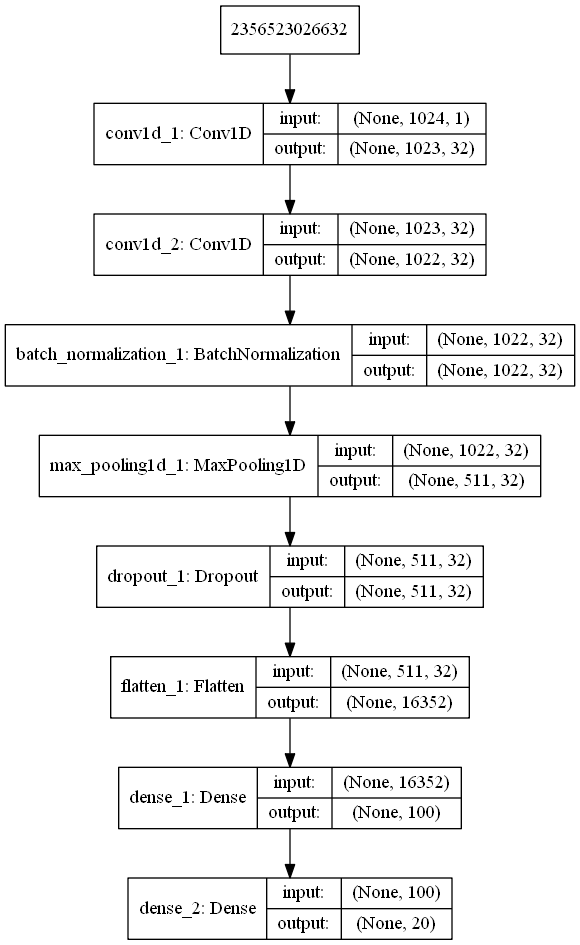

W0817 00:17:54.204052  2724 deprecation.py:323] From C:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 65s 365us/step - loss: 1.1294 - acc: 0.7067 - val_loss: 0.6012 - val_acc: 0.8307
Epoch 2/100
178346/178346 [==============================] - 59s 333us/step - loss: 0.5464 - acc: 0.8479 - val_loss: 0.4550 - val_acc: 0.8773
Epoch 3/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.4237 - acc: 0.8806 - val_loss: 0.3837 - val_acc: 0.8942
Epoch 4/100
178346/178346 [==============================] - 60s 334us/step - loss: 0.3615 - acc: 0.8967 - val_loss: 0.3579 - val_acc: 0.9019
Epoch 5/100
178346/178346 [==============================] - 60s 334us/step - loss: 0.3250 - acc: 0.9057 - val_loss: 0.3188 - val_acc: 0.9100
Epoch 6/100
178346/178346 [==============================] - 59s 333us/step - loss: 0.2982 - acc: 0.9128 - val_loss: 0.3126 - val_acc: 0.9121
Epoch 7/100
178346/178346 [==============================] - 59s 332us/step - loss: 0.2822 - acc:

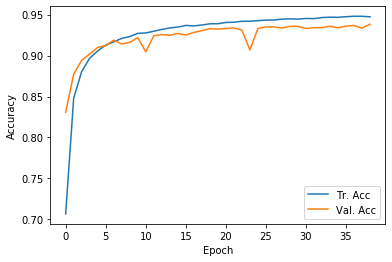

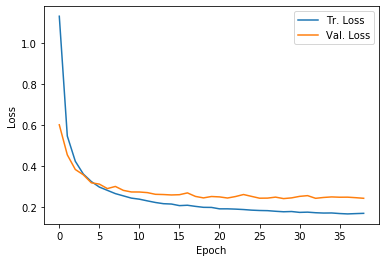

--- Test set evaluation ---
Loss              : 0.2536
Accuracy          : 0.9331
Balanced accuracy : 0.8224


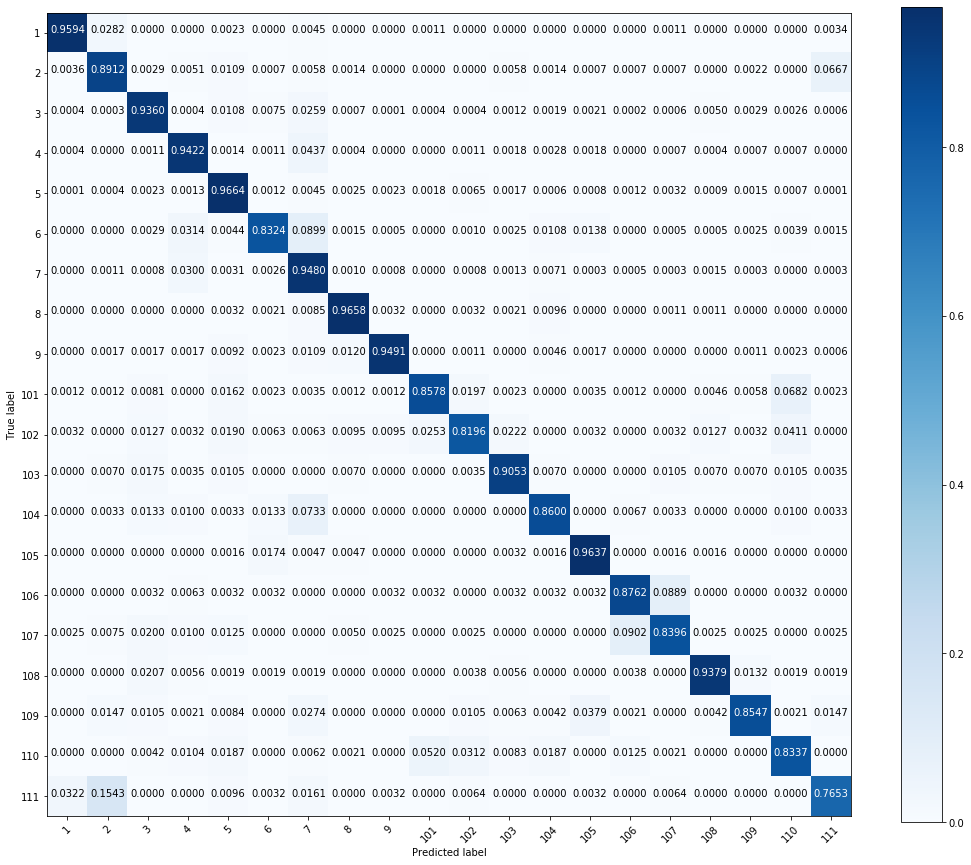

===== Model 1: filters = 32, kernel size = 2, pooling size = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1023, 32)          96        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1022, 32)          2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1022, 32)          128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 340, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 340, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10880)             0         
_________________________________________________________________
dense_3 (Dens

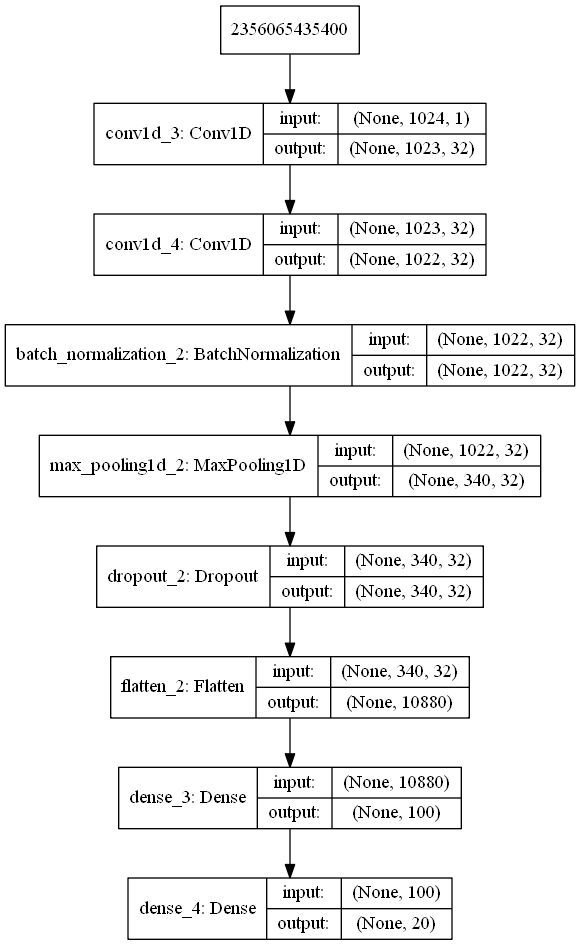

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 56s 315us/step - loss: 1.2522 - acc: 0.6774 - val_loss: 0.7071 - val_acc: 0.8050
Epoch 2/100
178346/178346 [==============================] - 56s 311us/step - loss: 0.6440 - acc: 0.8224 - val_loss: 0.5164 - val_acc: 0.8616
Epoch 3/100
178346/178346 [==============================] - 56s 312us/step - loss: 0.5019 - acc: 0.8589 - val_loss: 0.4355 - val_acc: 0.8834
Epoch 4/100
178346/178346 [==============================] - 56s 311us/step - loss: 0.4321 - acc: 0.8772 - val_loss: 0.3893 - val_acc: 0.8939
Epoch 5/100
178346/178346 [==============================] - 56s 312us/step - loss: 0.3833 - acc: 0.8901 - val_loss: 0.3427 - val_acc: 0.9062
Epoch 6/100
178346/178346 [==============================] - 56s 313us/step - loss: 0.3499 - acc: 0.8986 - val_loss: 0.3396 - val_acc: 0.9048
Epoch 7/100
178346/178346 [==============================] - 56s 312us/step - loss: 0.3232 - acc:

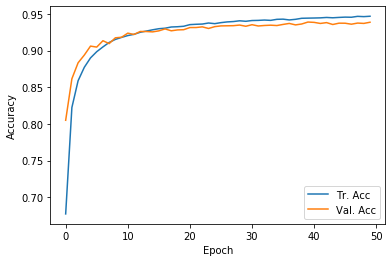

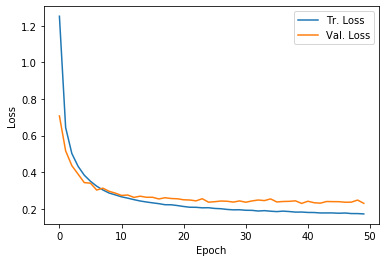

--- Test set evaluation ---
Loss              : 0.2395
Accuracy          : 0.9368
Balanced accuracy : 0.8265


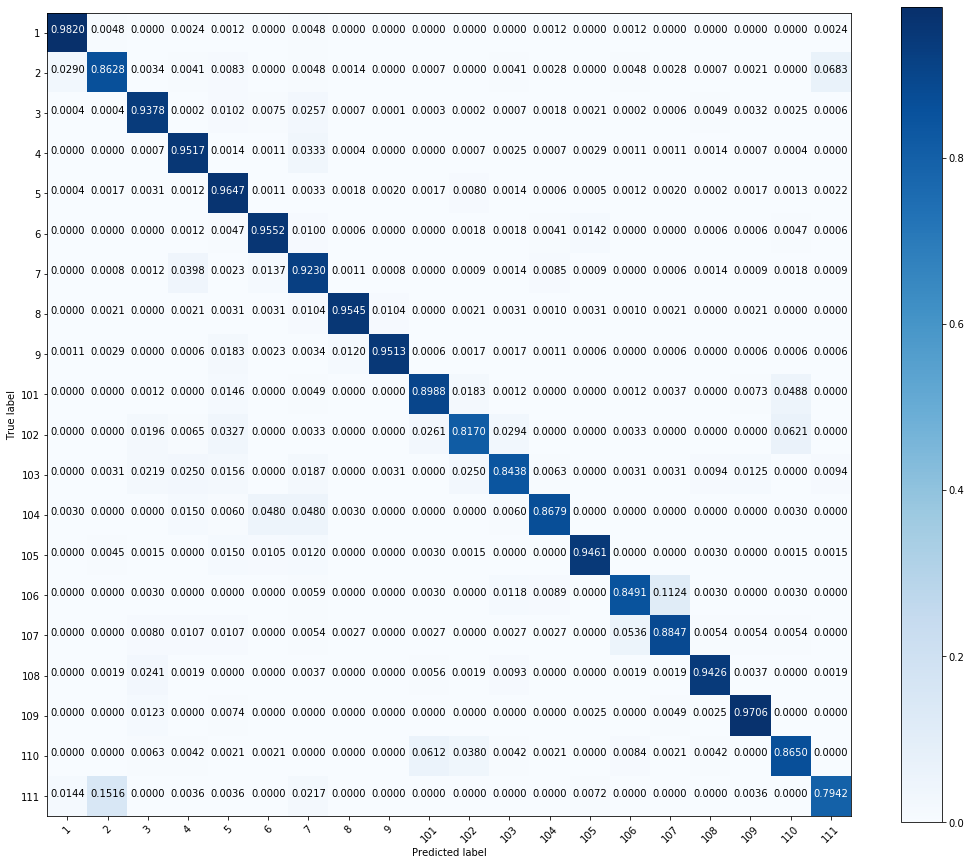

===== Model 2: filters = 32, kernel size = 2, pooling size = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1023, 32)          96        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1022, 32)          2080      
_________________________________________________________________
batch_normalization_3 (Batch (None, 1022, 32)          128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 255, 32)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 255, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8160)              0         
_________________________________________________________________
dense_5 (Dens

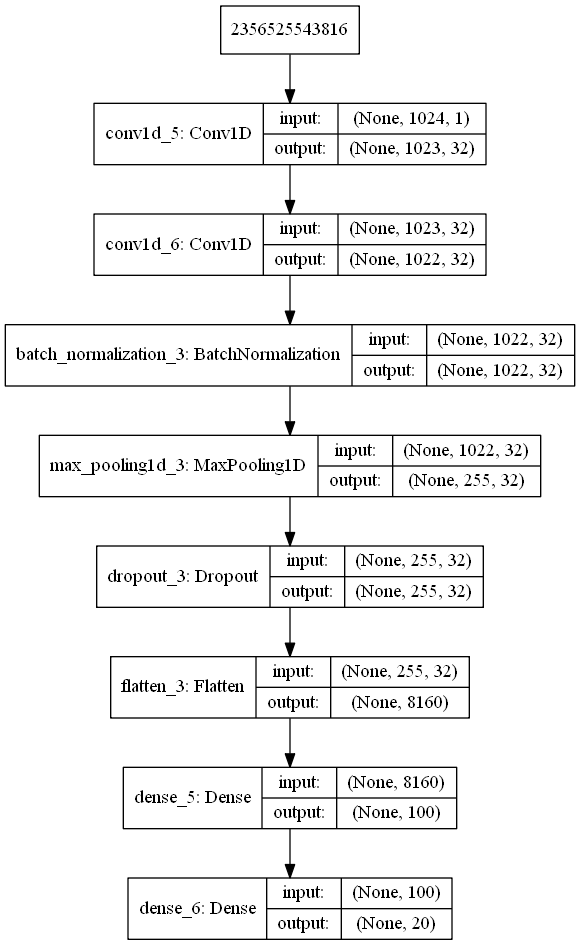

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 55s 309us/step - loss: 1.5237 - acc: 0.5920 - val_loss: 1.0460 - val_acc: 0.7019
Epoch 2/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.9170 - acc: 0.7418 - val_loss: 0.7918 - val_acc: 0.7841
Epoch 3/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.7415 - acc: 0.7905 - val_loss: 0.6383 - val_acc: 0.8204
Epoch 4/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.6508 - acc: 0.8157 - val_loss: 0.5748 - val_acc: 0.8388
Epoch 5/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.5881 - acc: 0.8336 - val_loss: 0.5404 - val_acc: 0.8491
Epoch 6/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.5451 - acc: 0.8453 - val_loss: 0.5133 - val_acc: 0.8594
Epoch 7/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.5073 - acc:

Epoch 58/100
178346/178346 [==============================] - 54s 305us/step - loss: 0.2569 - acc: 0.9221 - val_loss: 0.3081 - val_acc: 0.9161
Epoch 59/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.2565 - acc: 0.9221 - val_loss: 0.2968 - val_acc: 0.9172
Epoch 60/100
178346/178346 [==============================] - 56s 312us/step - loss: 0.2535 - acc: 0.9227 - val_loss: 0.3088 - val_acc: 0.9161
Epoch 61/100
178346/178346 [==============================] - 56s 312us/step - loss: 0.2541 - acc: 0.9222 - val_loss: 0.3009 - val_acc: 0.9174
Epoch 62/100
178346/178346 [==============================] - 56s 313us/step - loss: 0.2533 - acc: 0.9227 - val_loss: 0.3112 - val_acc: 0.9171
Epoch 63/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.2506 - acc: 0.9239 - val_loss: 0.3009 - val_acc: 0.9187
Epoch 64/100
178346/178346 [==============================] - 56s 315us/step - loss: 0.2511 - acc: 0.9233 - val_loss: 0.3255 - val_acc: 0.9095

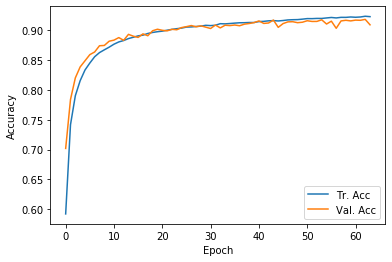

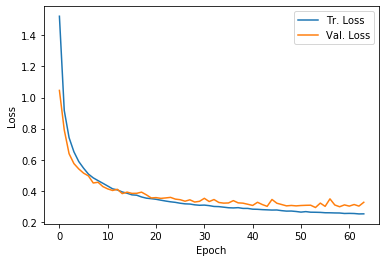

--- Test set evaluation ---
Loss              : 0.2994
Accuracy          : 0.9167
Balanced accuracy : 0.7579


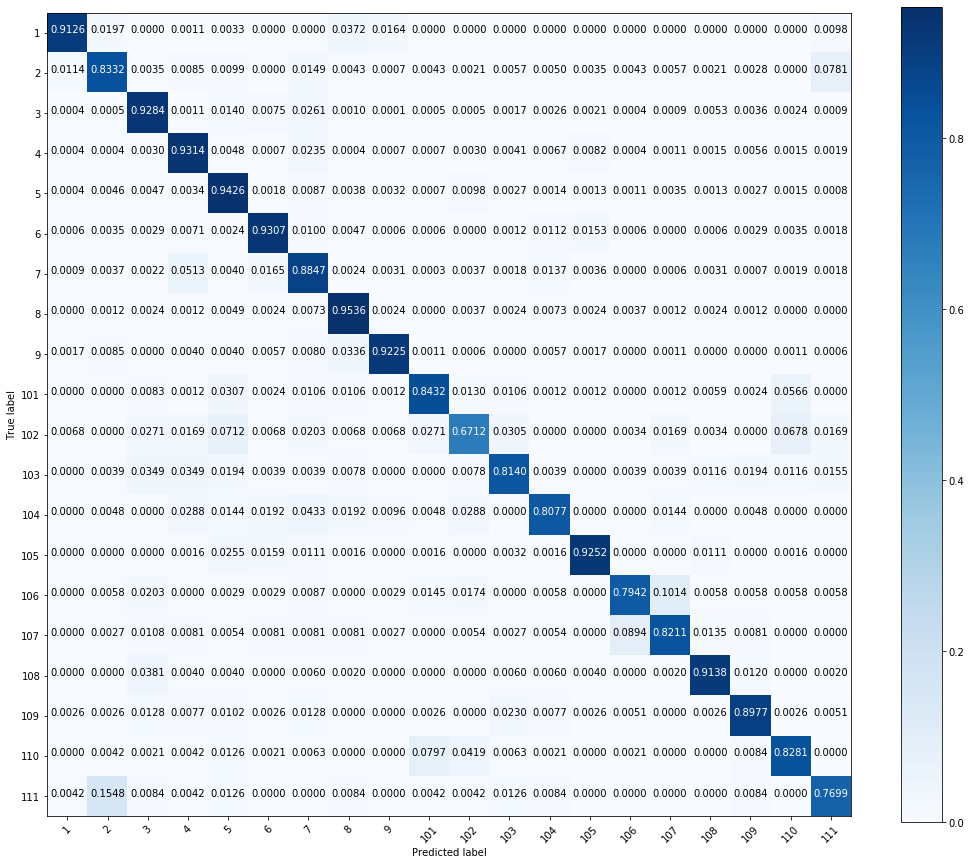

===== Model 3: filters = 32, kernel size = 3, pooling size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1022, 32)          128       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1020, 32)          3104      
_________________________________________________________________
batch_normalization_4 (Batch (None, 1020, 32)          128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 510, 32)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 510, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16320)             0         
_________________________________________________________________
dense_7 (Dens

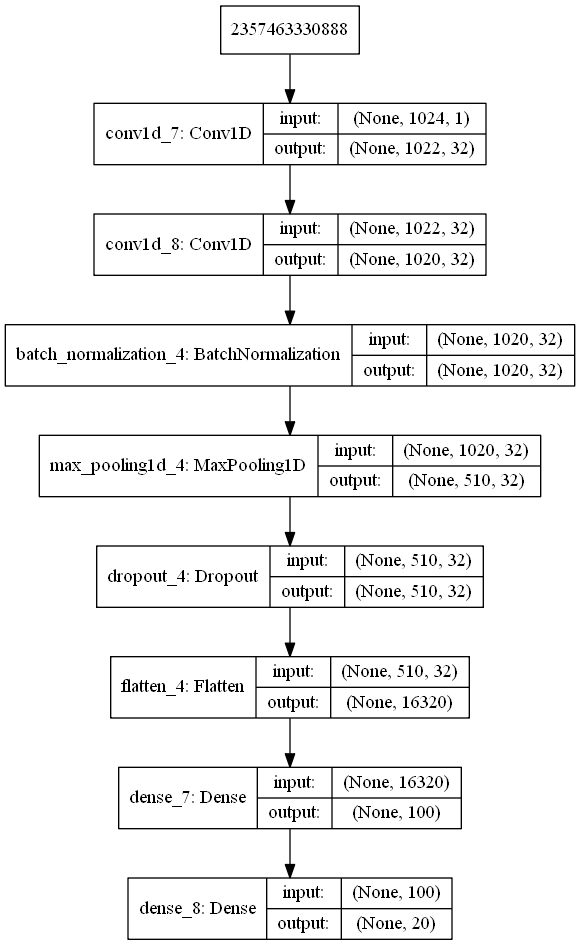

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 61s 342us/step - loss: 0.9501 - acc: 0.7518 - val_loss: 0.5191 - val_acc: 0.8519
Epoch 2/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.4621 - acc: 0.8689 - val_loss: 0.4054 - val_acc: 0.8841
Epoch 3/100
178346/178346 [==============================] - 60s 337us/step - loss: 0.3611 - acc: 0.8956 - val_loss: 0.3371 - val_acc: 0.9046
Epoch 4/100
178346/178346 [==============================] - 60s 336us/step - loss: 0.3090 - acc: 0.9097 - val_loss: 0.3124 - val_acc: 0.9152
Epoch 5/100
178346/178346 [==============================] - 60s 336us/step - loss: 0.2776 - acc: 0.9179 - val_loss: 0.2878 - val_acc: 0.9172
Epoch 6/100
178346/178346 [==============================] - 60s 336us/step - loss: 0.2529 - acc: 0.9252 - val_loss: 0.2845 - val_acc: 0.9170
Epoch 7/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.2407 - acc:

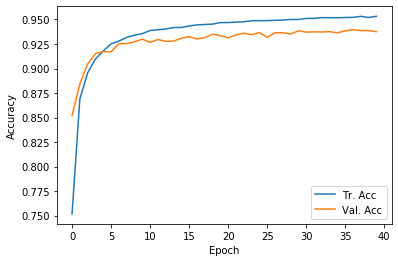

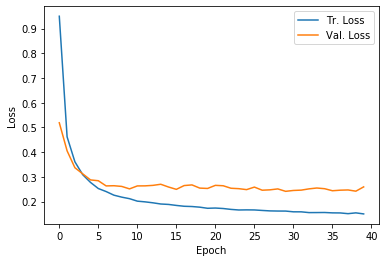

--- Test set evaluation ---
Loss              : 0.2561
Accuracy          : 0.9359
Balanced accuracy : 0.8224


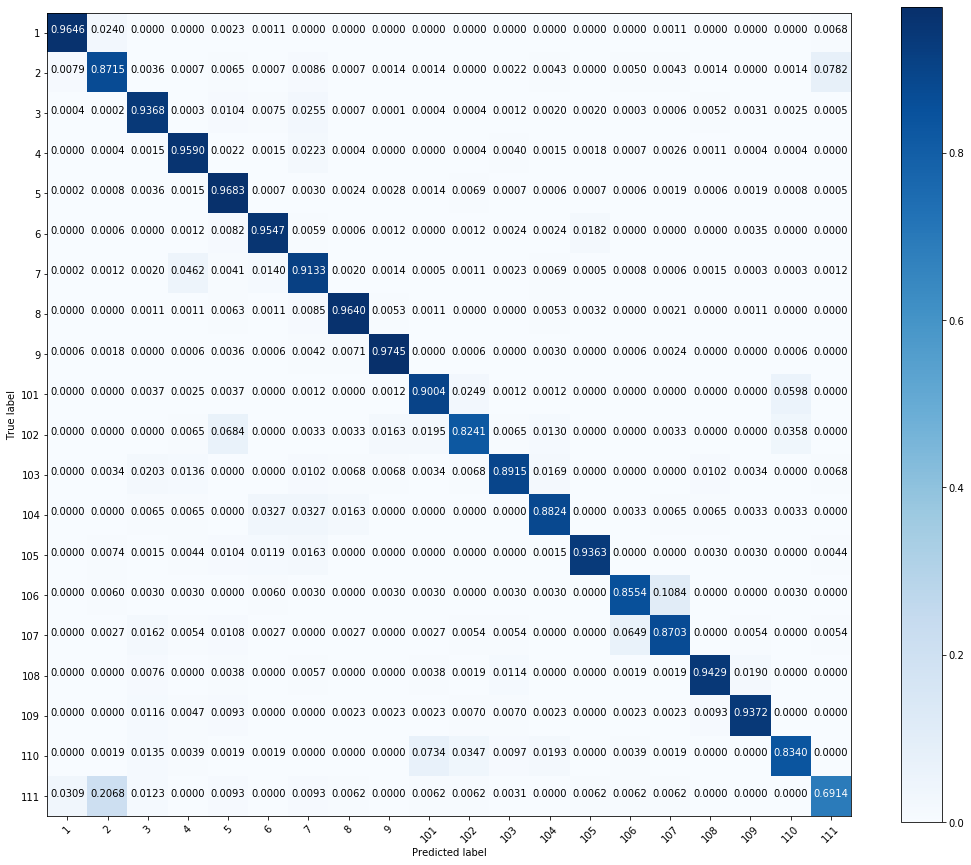

===== Model 4: filters = 32, kernel size = 3, pooling size = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1022, 32)          128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1020, 32)          3104      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1020, 32)          128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 340, 32)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 340, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10880)             0         
_________________________________________________________________
dense_9 (Dens

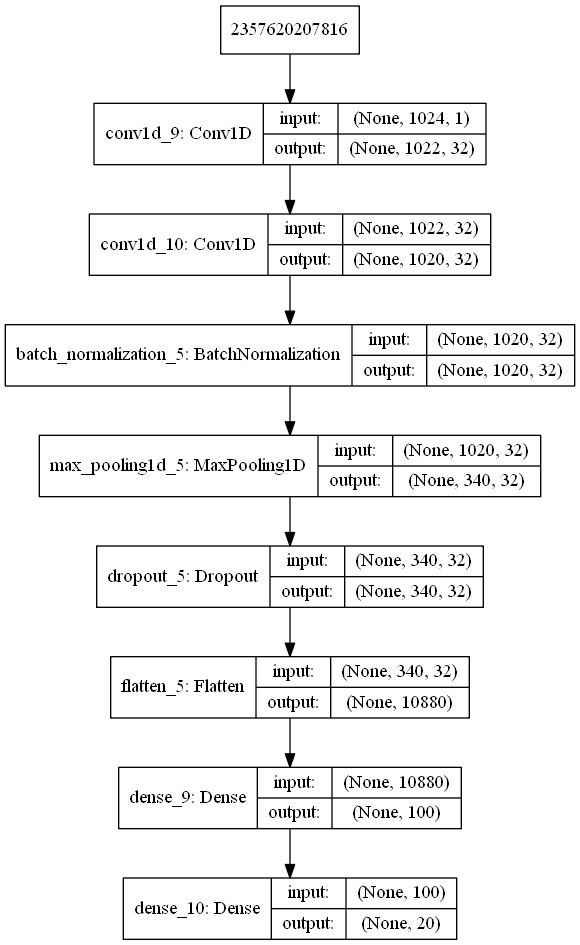

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 58s 324us/step - loss: 1.2803 - acc: 0.6724 - val_loss: 0.7483 - val_acc: 0.8047
Epoch 2/100
178346/178346 [==============================] - 57s 318us/step - loss: 0.6404 - acc: 0.8222 - val_loss: 0.5156 - val_acc: 0.8359
Epoch 3/100
178346/178346 [==============================] - 57s 317us/step - loss: 0.4940 - acc: 0.8597 - val_loss: 0.4220 - val_acc: 0.8825
Epoch 4/100
178346/178346 [==============================] - 57s 318us/step - loss: 0.4207 - acc: 0.8789 - val_loss: 0.3897 - val_acc: 0.8880
Epoch 5/100
178346/178346 [==============================] - 57s 319us/step - loss: 0.3751 - acc: 0.8914 - val_loss: 0.3517 - val_acc: 0.8989
Epoch 6/100
178346/178346 [==============================] - 57s 318us/step - loss: 0.3418 - acc: 0.9001 - val_loss: 0.3327 - val_acc: 0.9069
Epoch 7/100
178346/178346 [==============================] - 56s 317us/step - loss: 0.3203 - acc:

Epoch 58/100
178346/178346 [==============================] - 57s 318us/step - loss: 0.1620 - acc: 0.9494 - val_loss: 0.2318 - val_acc: 0.9381
Epoch 59/100
178346/178346 [==============================] - 57s 319us/step - loss: 0.1633 - acc: 0.9492 - val_loss: 0.2414 - val_acc: 0.9379
Epoch 60/100
178346/178346 [==============================] - 57s 318us/step - loss: 0.1622 - acc: 0.9494 - val_loss: 0.2335 - val_acc: 0.9380
Epoch 61/100
178346/178346 [==============================] - 57s 318us/step - loss: 0.1618 - acc: 0.9493 - val_loss: 0.2384 - val_acc: 0.9385


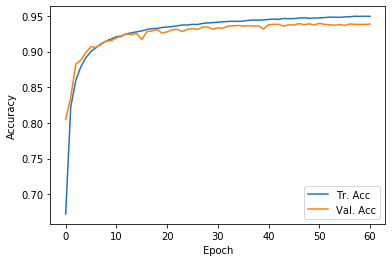

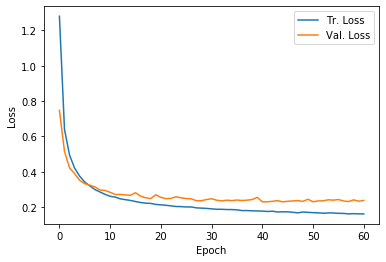

--- Test set evaluation ---
Loss              : 0.2436
Accuracy          : 0.9376
Balanced accuracy : 0.8329


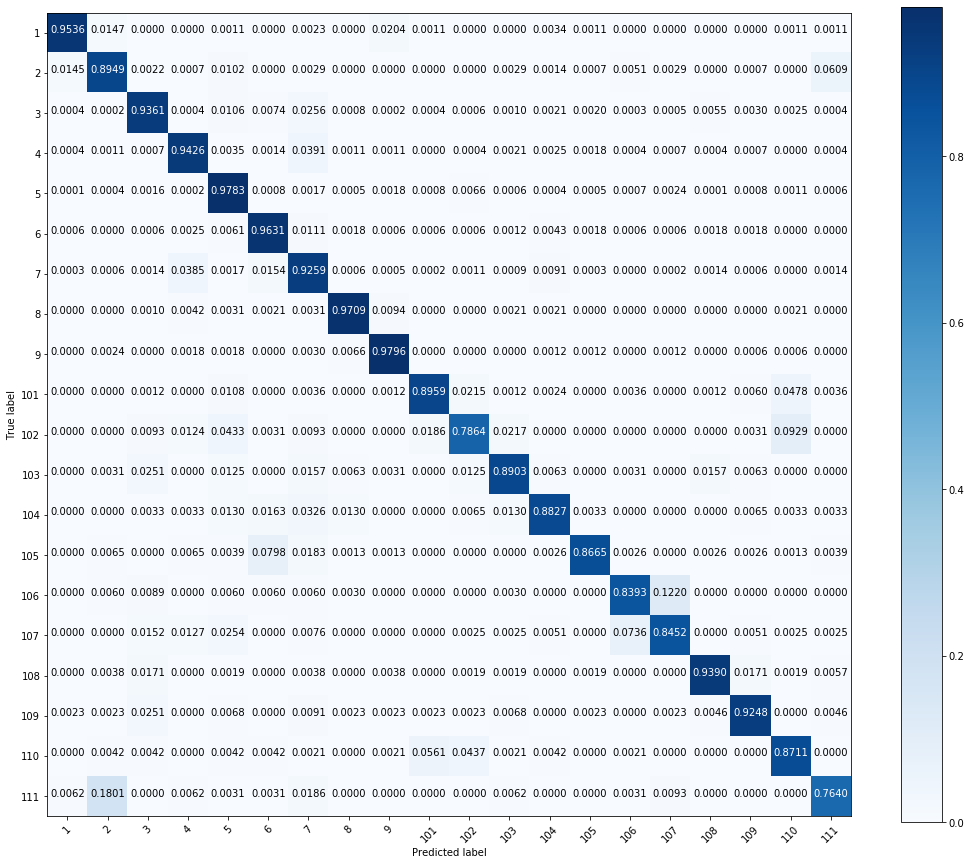

===== Model 5: filters = 32, kernel size = 3, pooling size = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 1022, 32)          128       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1020, 32)          3104      
_________________________________________________________________
batch_normalization_6 (Batch (None, 1020, 32)          128       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 255, 32)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 255, 32)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8160)              0         
_________________________________________________________________
dense_11 (Den

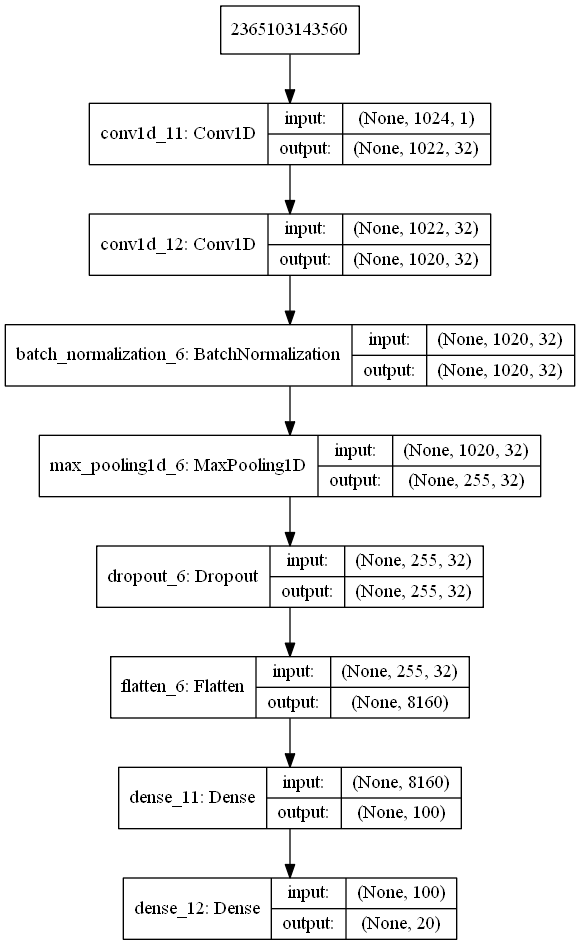

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 56s 317us/step - loss: 1.4042 - acc: 0.6347 - val_loss: 0.8408 - val_acc: 0.7678
Epoch 2/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.7552 - acc: 0.7870 - val_loss: 0.6137 - val_acc: 0.8289
Epoch 3/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.6017 - acc: 0.8297 - val_loss: 0.5237 - val_acc: 0.8531
Epoch 4/100
178346/178346 [==============================] - 55s 311us/step - loss: 0.5235 - acc: 0.8514 - val_loss: 0.4645 - val_acc: 0.8727
Epoch 5/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.4785 - acc: 0.8629 - val_loss: 0.4476 - val_acc: 0.8736
Epoch 6/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.4443 - acc: 0.8720 - val_loss: 0.4187 - val_acc: 0.8801
Epoch 7/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.4190 - acc:

Epoch 58/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.2326 - acc: 0.9285 - val_loss: 0.2860 - val_acc: 0.9217
Epoch 59/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.2278 - acc: 0.9305 - val_loss: 0.2867 - val_acc: 0.9201
Epoch 60/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.2303 - acc: 0.9295 - val_loss: 0.2973 - val_acc: 0.9208
Epoch 61/100
178346/178346 [==============================] - 55s 309us/step - loss: 0.2286 - acc: 0.9300 - val_loss: 0.2868 - val_acc: 0.9216
Epoch 62/100
178346/178346 [==============================] - 55s 309us/step - loss: 0.2272 - acc: 0.9308 - val_loss: 0.2848 - val_acc: 0.9225
Epoch 63/100
178346/178346 [==============================] - 55s 309us/step - loss: 0.2256 - acc: 0.9304 - val_loss: 0.2849 - val_acc: 0.9219
Epoch 64/100
178346/178346 [==============================] - 55s 310us/step - loss: 0.2278 - acc: 0.9297 - val_loss: 0.2965 - val_acc: 0.9208

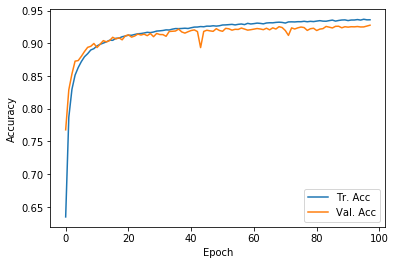

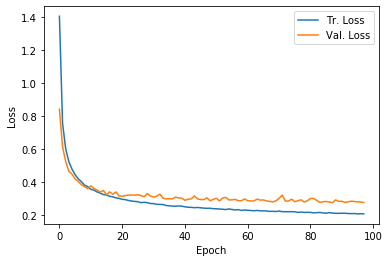

--- Test set evaluation ---
Loss              : 0.2857
Accuracy          : 0.9229
Balanced accuracy : 0.7901


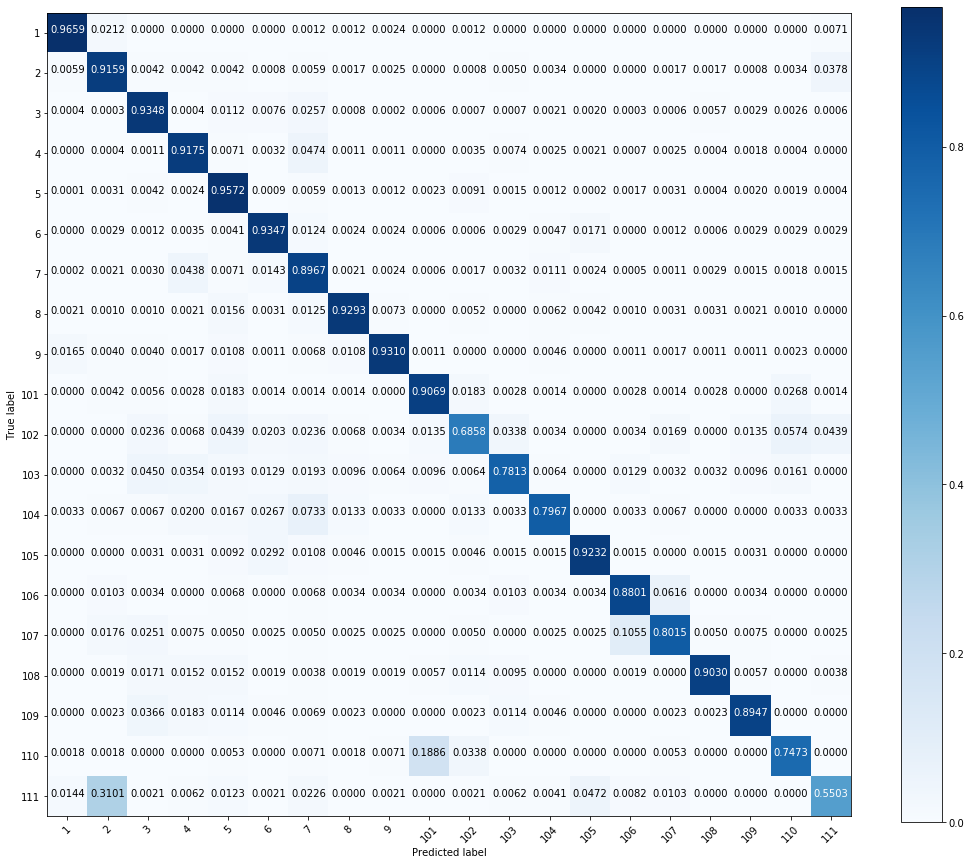

===== Model 6: filters = 32, kernel size = 4, pooling size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 1021, 32)          160       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1018, 32)          4128      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1018, 32)          128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 509, 32)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 509, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16288)             0         
_________________________________________________________________
dense_13 (Den

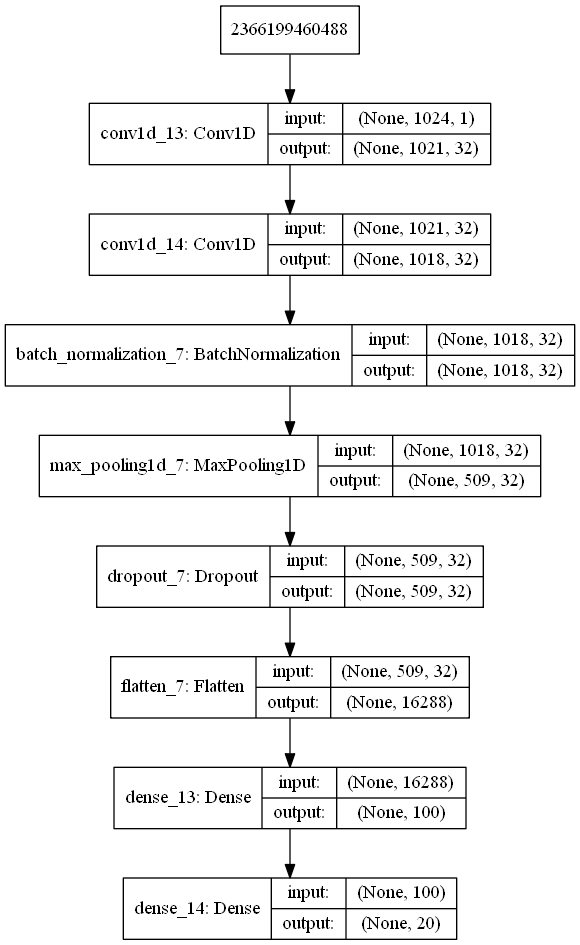

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 61s 343us/step - loss: 1.1136 - acc: 0.7343 - val_loss: 0.5367 - val_acc: 0.8531
Epoch 2/100
178346/178346 [==============================] - 60s 334us/step - loss: 0.4844 - acc: 0.8639 - val_loss: 0.4104 - val_acc: 0.8833
Epoch 3/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.3832 - acc: 0.8897 - val_loss: 0.3558 - val_acc: 0.8990
Epoch 4/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.3305 - acc: 0.9043 - val_loss: 0.3790 - val_acc: 0.8709
Epoch 5/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.3014 - acc: 0.9109 - val_loss: 0.3180 - val_acc: 0.9087
Epoch 6/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.2755 - acc: 0.9178 - val_loss: 0.2959 - val_acc: 0.9147
Epoch 7/100
178346/178346 [==============================] - 60s 335us/step - loss: 0.2587 - acc:

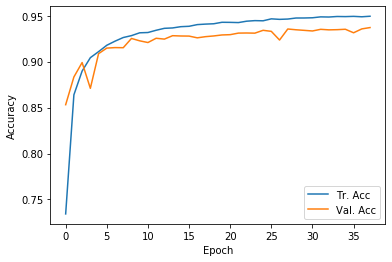

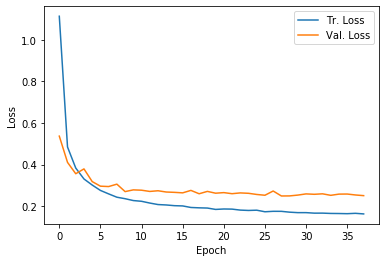

--- Test set evaluation ---
Loss              : 0.2619
Accuracy          : 0.9340
Balanced accuracy : 0.8204


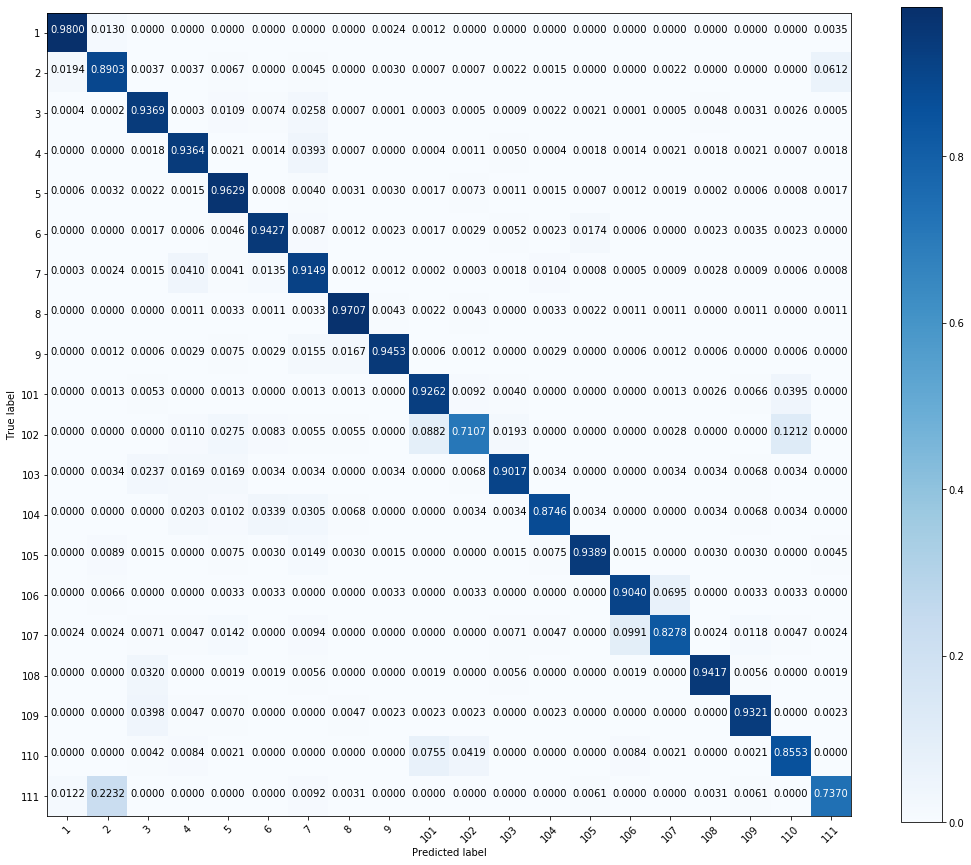

===== Model 7: filters = 32, kernel size = 4, pooling size = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 1021, 32)          160       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1018, 32)          4128      
_________________________________________________________________
batch_normalization_8 (Batch (None, 1018, 32)          128       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 339, 32)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 339, 32)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 10848)             0         
_________________________________________________________________
dense_15 (Den

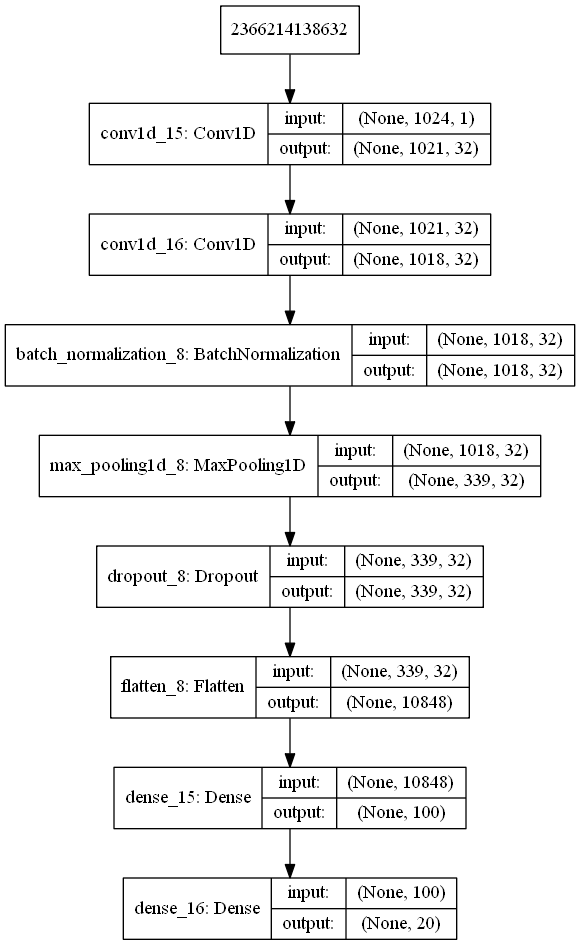

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 59s 329us/step - loss: 1.2197 - acc: 0.6845 - val_loss: 0.7060 - val_acc: 0.8042
Epoch 2/100
178346/178346 [==============================] - 57s 322us/step - loss: 0.5941 - acc: 0.8322 - val_loss: 0.4960 - val_acc: 0.8602
Epoch 3/100
178346/178346 [==============================] - 57s 321us/step - loss: 0.4658 - acc: 0.8663 - val_loss: 0.4090 - val_acc: 0.8835
Epoch 4/100
178346/178346 [==============================] - 58s 323us/step - loss: 0.4008 - acc: 0.8833 - val_loss: 0.3633 - val_acc: 0.8952
Epoch 5/100
178346/178346 [==============================] - 57s 322us/step - loss: 0.3599 - acc: 0.8948 - val_loss: 0.3559 - val_acc: 0.8986
Epoch 6/100
178346/178346 [==============================] - 57s 321us/step - loss: 0.3306 - acc: 0.9017 - val_loss: 0.3515 - val_acc: 0.8830
Epoch 7/100
178346/178346 [==============================] - 57s 321us/step - loss: 0.3051 - acc:

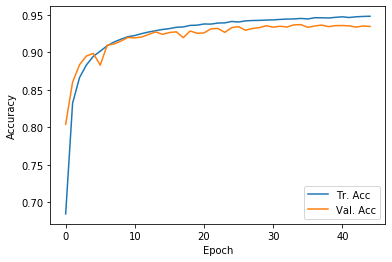

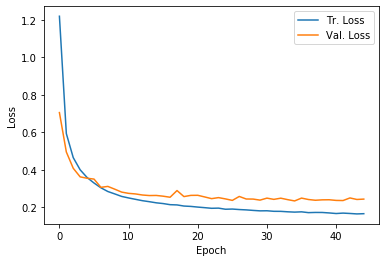

--- Test set evaluation ---
Loss              : 0.2434
Accuracy          : 0.9351
Balanced accuracy : 0.8230


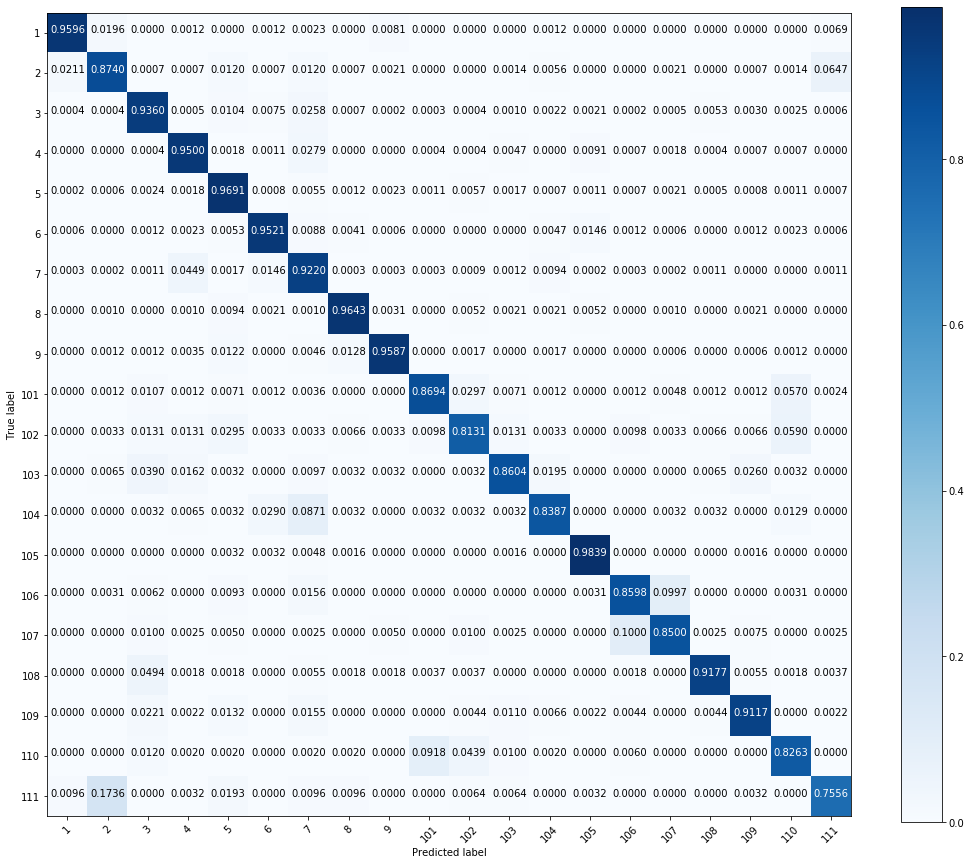

===== Model 8: filters = 32, kernel size = 4, pooling size = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 1021, 32)          160       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1018, 32)          4128      
_________________________________________________________________
batch_normalization_9 (Batch (None, 1018, 32)          128       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 254, 32)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 254, 32)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8128)              0         
_________________________________________________________________
dense_17 (Den

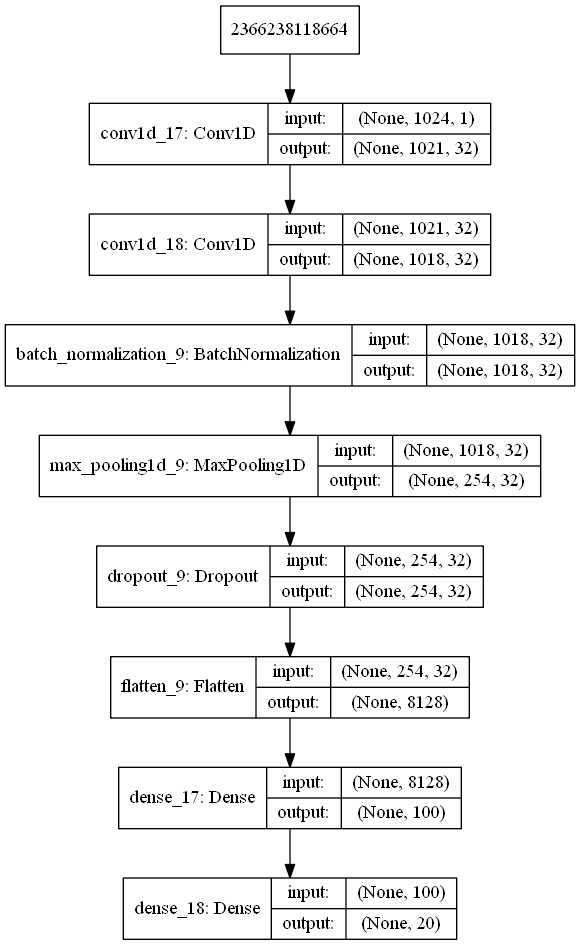

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 57s 321us/step - loss: 1.3808 - acc: 0.6381 - val_loss: 0.9117 - val_acc: 0.7458
Epoch 2/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.8033 - acc: 0.7769 - val_loss: 0.6758 - val_acc: 0.8143
Epoch 3/100
178346/178346 [==============================] - 56s 313us/step - loss: 0.6406 - acc: 0.8208 - val_loss: 0.5761 - val_acc: 0.8401
Epoch 4/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.5530 - acc: 0.8418 - val_loss: 0.4884 - val_acc: 0.8630
Epoch 5/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.4953 - acc: 0.8572 - val_loss: 0.4699 - val_acc: 0.8688
Epoch 6/100
178346/178346 [==============================] - 56s 313us/step - loss: 0.4517 - acc: 0.8688 - val_loss: 0.4322 - val_acc: 0.8786
Epoch 7/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.4236 - acc:

Epoch 58/100
178346/178346 [==============================] - 56s 315us/step - loss: 0.2128 - acc: 0.9345 - val_loss: 0.3065 - val_acc: 0.9191
Epoch 59/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.2161 - acc: 0.9338 - val_loss: 0.2963 - val_acc: 0.9204
Epoch 60/100
178346/178346 [==============================] - 56s 316us/step - loss: 0.2155 - acc: 0.9338 - val_loss: 0.3020 - val_acc: 0.9211
Epoch 61/100
178346/178346 [==============================] - 56s 315us/step - loss: 0.2137 - acc: 0.9345 - val_loss: 0.2964 - val_acc: 0.9219
Epoch 62/100
178346/178346 [==============================] - 56s 314us/step - loss: 0.2120 - acc: 0.9344 - val_loss: 0.2970 - val_acc: 0.9216


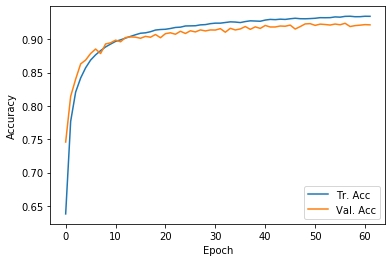

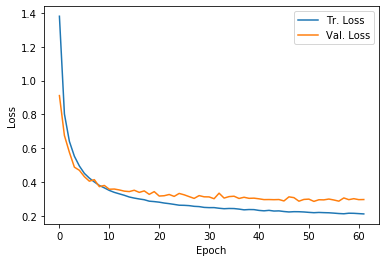

--- Test set evaluation ---
Loss              : 0.3030
Accuracy          : 0.9213
Balanced accuracy : 0.7752


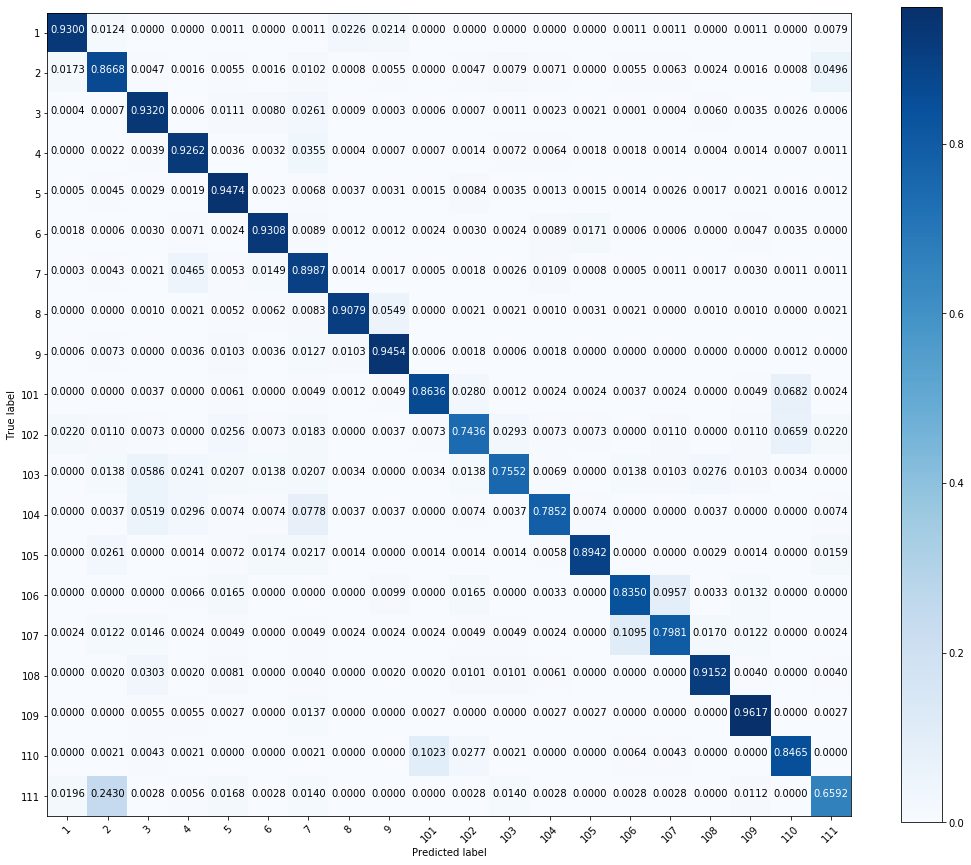

===== Model 9: filters = 64, kernel size = 2, pooling size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 1023, 64)          192       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1022, 64)          8256      
_________________________________________________________________
batch_normalization_10 (Batc (None, 1022, 64)          256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 511, 64)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 511, 64)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32704)             0         
_________________________________________________________________
dense_19 (Den

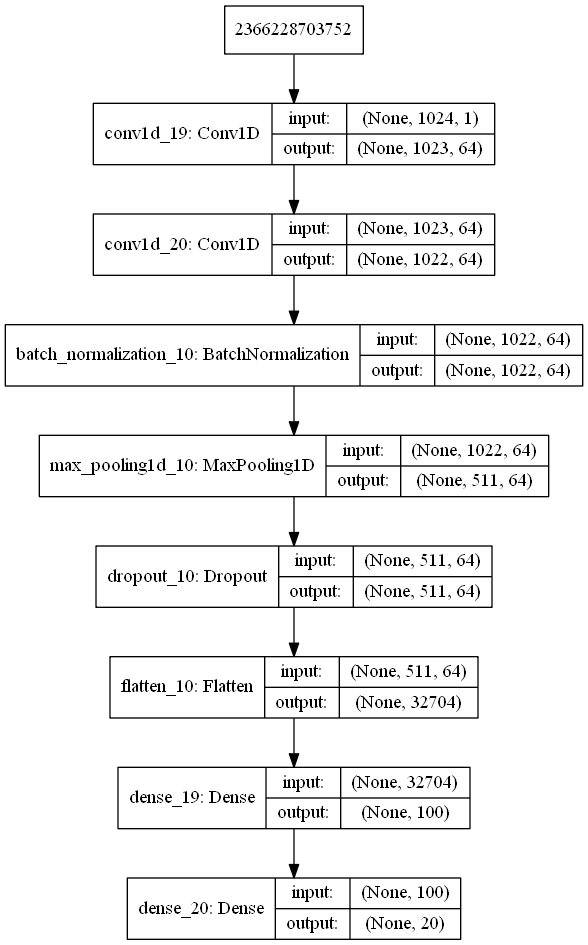

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 106s 595us/step - loss: 1.2306 - acc: 0.6918 - val_loss: 0.6632 - val_acc: 0.8139
Epoch 2/100
178346/178346 [==============================] - 104s 583us/step - loss: 0.5844 - acc: 0.8383 - val_loss: 0.5186 - val_acc: 0.8564
Epoch 3/100
178346/178346 [==============================] - 104s 584us/step - loss: 0.4612 - acc: 0.8712 - val_loss: 0.4489 - val_acc: 0.8818
Epoch 4/100
178346/178346 [==============================] - 104s 583us/step - loss: 0.3978 - acc: 0.8873 - val_loss: 0.3725 - val_acc: 0.8962
Epoch 5/100
178346/178346 [==============================] - 104s 583us/step - loss: 0.3547 - acc: 0.8979 - val_loss: 0.3379 - val_acc: 0.9047
Epoch 6/100
178346/178346 [==============================] - 104s 584us/step - loss: 0.3283 - acc: 0.9043 - val_loss: 0.3323 - val_acc: 0.9060
Epoch 7/100
178346/178346 [==============================] - 104s 582us/step - loss: 0.3042

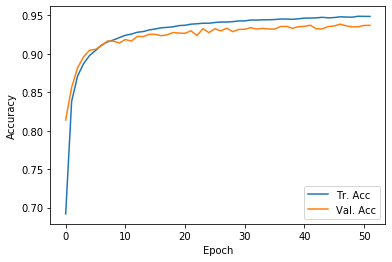

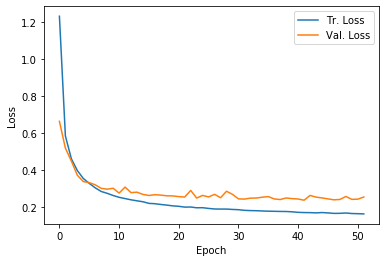

--- Test set evaluation ---
Loss              : 0.2527
Accuracy          : 0.9361
Balanced accuracy : 0.8228


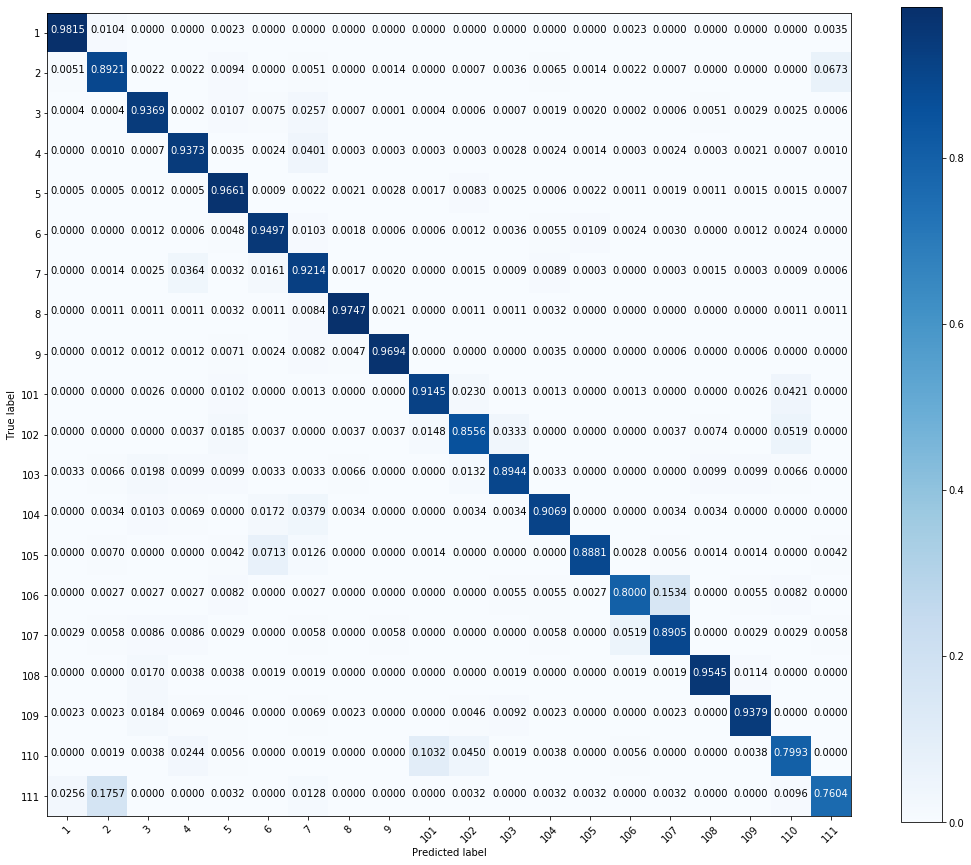

===== Model 10: filters = 64, kernel size = 2, pooling size = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 1023, 64)          192       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1022, 64)          8256      
_________________________________________________________________
batch_normalization_11 (Batc (None, 1022, 64)          256       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 340, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 340, 64)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 21760)             0         
_________________________________________________________________
dense_21 (De

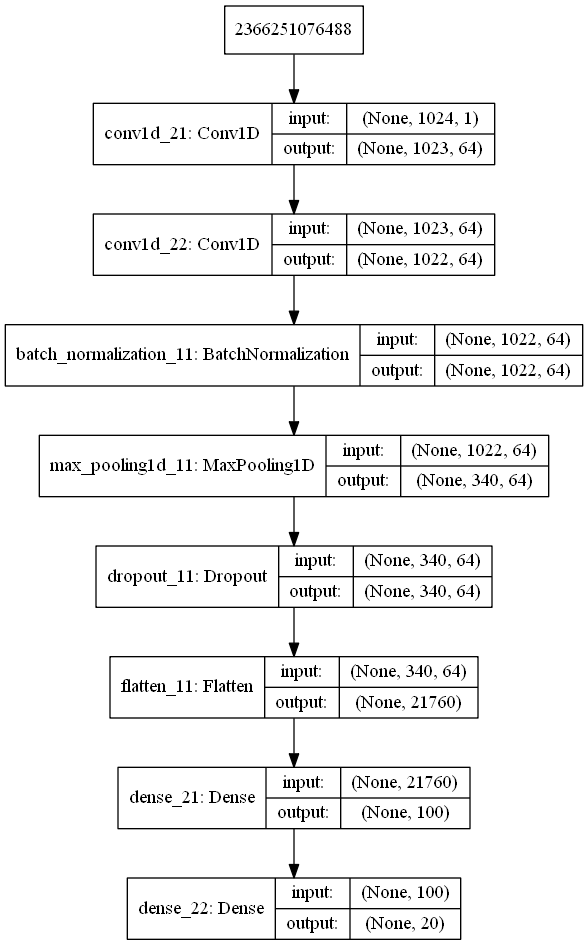

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 100s 563us/step - loss: 1.5302 - acc: 0.6494 - val_loss: 0.7486 - val_acc: 0.7935
Epoch 2/100
178346/178346 [==============================] - 99s 556us/step - loss: 0.6568 - acc: 0.8167 - val_loss: 0.5134 - val_acc: 0.8600
Epoch 3/100
178346/178346 [==============================] - 99s 555us/step - loss: 0.5042 - acc: 0.8566 - val_loss: 0.4297 - val_acc: 0.8809
Epoch 4/100
178346/178346 [==============================] - 99s 555us/step - loss: 0.4288 - acc: 0.8775 - val_loss: 0.3869 - val_acc: 0.8913
Epoch 5/100
178346/178346 [==============================] - 99s 555us/step - loss: 0.3850 - acc: 0.8886 - val_loss: 0.3549 - val_acc: 0.8994
Epoch 6/100
178346/178346 [==============================] - 99s 555us/step - loss: 0.3527 - acc: 0.8978 - val_loss: 0.3458 - val_acc: 0.9042
Epoch 7/100
178346/178346 [==============================] - 99s 555us/step - loss: 0.3295 - acc

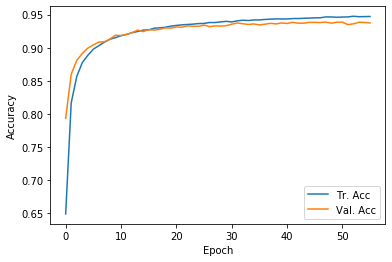

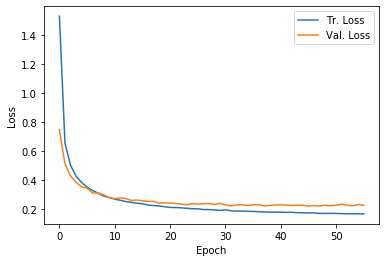

--- Test set evaluation ---
Loss              : 0.2362
Accuracy          : 0.9351
Balanced accuracy : 0.8285


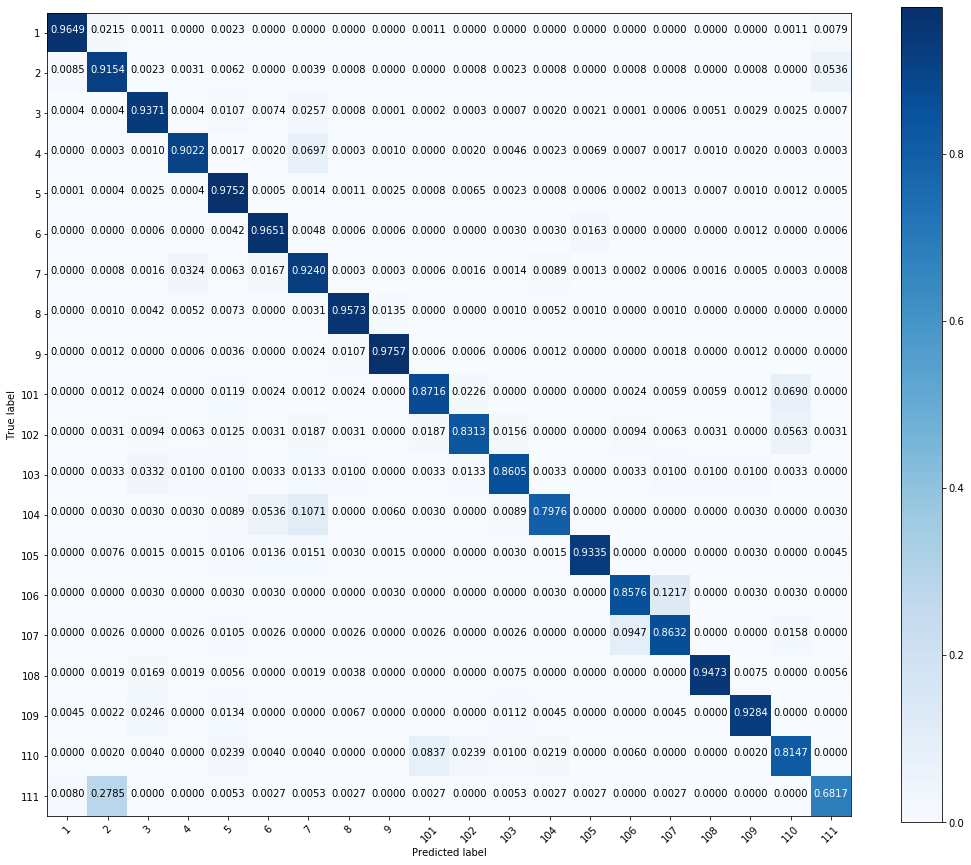

===== Model 11: filters = 64, kernel size = 2, pooling size = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 1023, 64)          192       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1022, 64)          8256      
_________________________________________________________________
batch_normalization_12 (Batc (None, 1022, 64)          256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 255, 64)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 255, 64)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 16320)             0         
_________________________________________________________________
dense_23 (De

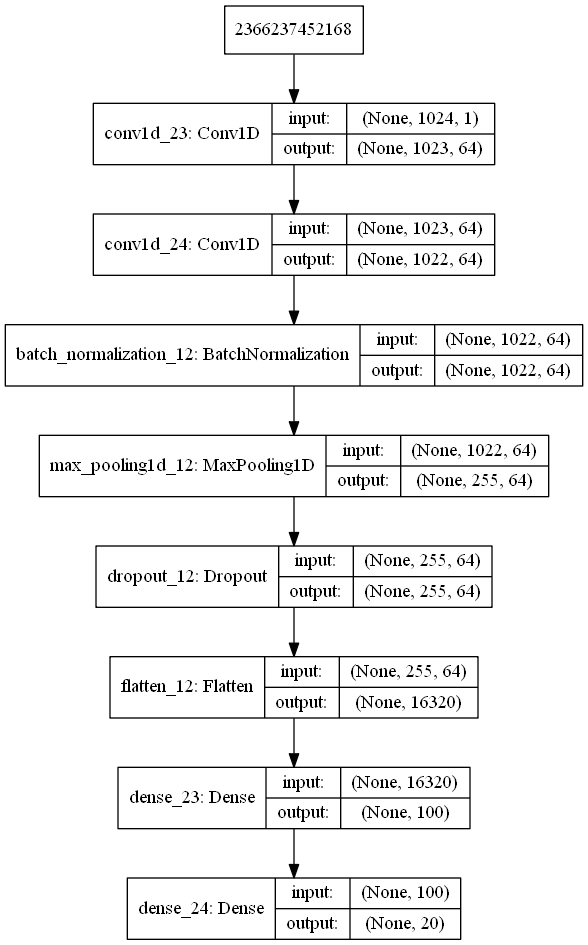

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 98s 552us/step - loss: 1.5104 - acc: 0.5982 - val_loss: 1.1596 - val_acc: 0.6741
Epoch 2/100
178346/178346 [==============================] - 97s 543us/step - loss: 0.9446 - acc: 0.7380 - val_loss: 0.7973 - val_acc: 0.7785
Epoch 3/100
178346/178346 [==============================] - 97s 545us/step - loss: 0.7725 - acc: 0.7843 - val_loss: 0.6719 - val_acc: 0.8151
Epoch 4/100
178346/178346 [==============================] - 97s 542us/step - loss: 0.6879 - acc: 0.8066 - val_loss: 0.6199 - val_acc: 0.8243
Epoch 5/100
178346/178346 [==============================] - 96s 540us/step - loss: 0.6401 - acc: 0.8196 - val_loss: 0.6104 - val_acc: 0.8319
Epoch 6/100
178346/178346 [==============================] - 96s 539us/step - loss: 0.6076 - acc: 0.8280 - val_loss: 0.5633 - val_acc: 0.8409
Epoch 7/100
178346/178346 [==============================] - 96s 539us/step - loss: 0.5767 - acc:

Epoch 58/100
178346/178346 [==============================] - 96s 541us/step - loss: 0.3256 - acc: 0.9034 - val_loss: 0.3510 - val_acc: 0.9028
Epoch 59/100
178346/178346 [==============================] - 96s 540us/step - loss: 0.3258 - acc: 0.9032 - val_loss: 0.3391 - val_acc: 0.9059
Epoch 60/100
178346/178346 [==============================] - 96s 540us/step - loss: 0.3231 - acc: 0.9041 - val_loss: 0.3480 - val_acc: 0.9019
Epoch 61/100
178346/178346 [==============================] - 96s 540us/step - loss: 0.3237 - acc: 0.9040 - val_loss: 0.3334 - val_acc: 0.9050
Epoch 62/100
178346/178346 [==============================] - 96s 540us/step - loss: 0.3214 - acc: 0.9046 - val_loss: 0.3411 - val_acc: 0.9054
Epoch 63/100
178346/178346 [==============================] - 96s 539us/step - loss: 0.3210 - acc: 0.9050 - val_loss: 0.3298 - val_acc: 0.9094
Epoch 64/100
178346/178346 [==============================] - 96s 540us/step - loss: 0.3198 - acc: 0.9043 - val_loss: 0.3311 - val_acc: 0.9073

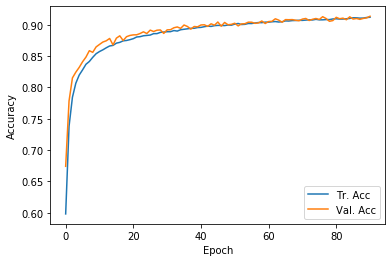

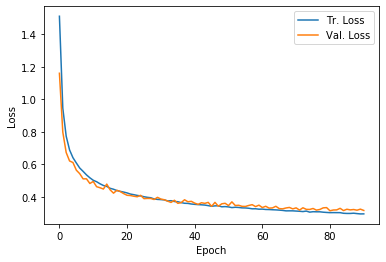

--- Test set evaluation ---
Loss              : 0.3276
Accuracy          : 0.9103
Balanced accuracy : 0.7445


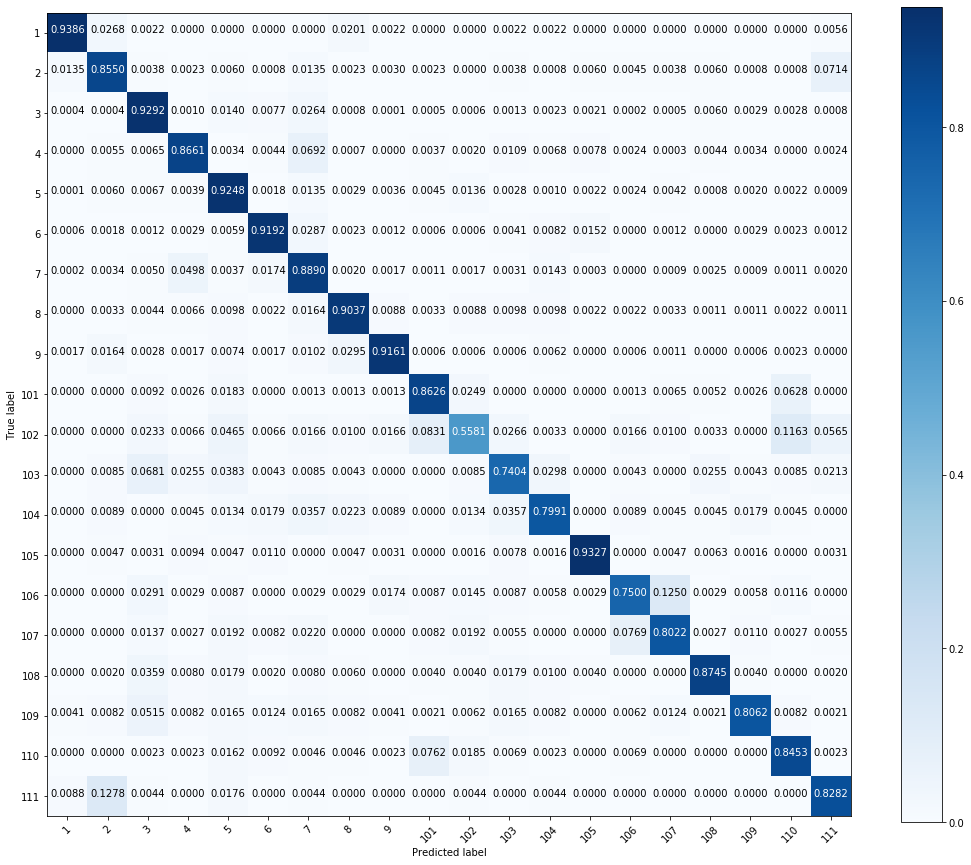

===== Model 12: filters = 64, kernel size = 3, pooling size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 1022, 64)          256       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1020, 64)          12352     
_________________________________________________________________
batch_normalization_13 (Batc (None, 1020, 64)          256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 510, 64)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 510, 64)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 32640)             0         
_________________________________________________________________
dense_25 (De

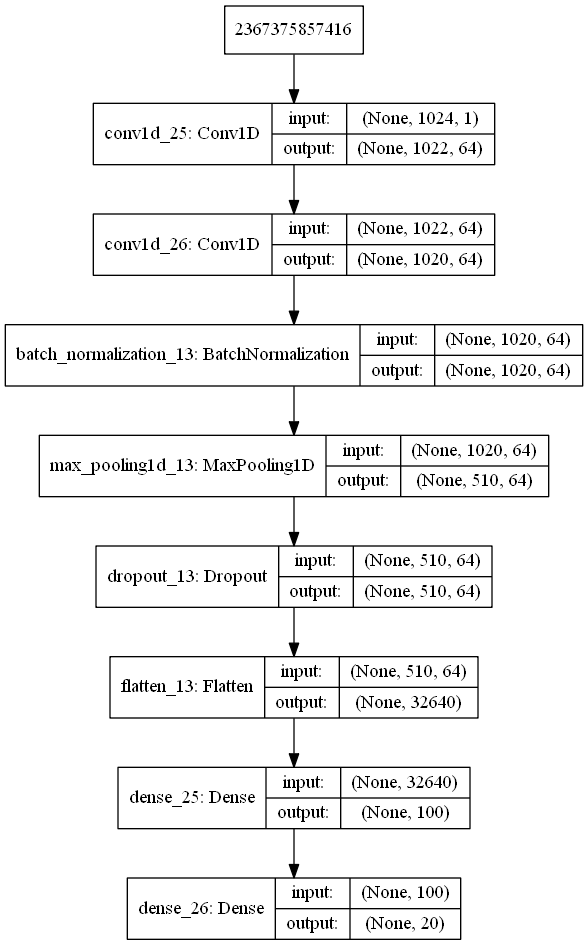

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 112s 629us/step - loss: 1.1564 - acc: 0.7284 - val_loss: 0.5626 - val_acc: 0.8441
Epoch 2/100
178346/178346 [==============================] - 110s 615us/step - loss: 0.4981 - acc: 0.8599 - val_loss: 0.4278 - val_acc: 0.8820
Epoch 3/100
178346/178346 [==============================] - 110s 615us/step - loss: 0.3940 - acc: 0.8873 - val_loss: 0.3754 - val_acc: 0.8962
Epoch 4/100
178346/178346 [==============================] - 110s 616us/step - loss: 0.3403 - acc: 0.9008 - val_loss: 0.3394 - val_acc: 0.9023
Epoch 5/100
178346/178346 [==============================] - 110s 616us/step - loss: 0.3084 - acc: 0.9093 - val_loss: 0.3032 - val_acc: 0.9132
Epoch 6/100
178346/178346 [==============================] - 110s 617us/step - loss: 0.2844 - acc: 0.9155 - val_loss: 0.3111 - val_acc: 0.9127
Epoch 7/100
178346/178346 [==============================] - 112s 627us/step - loss: 0.2672

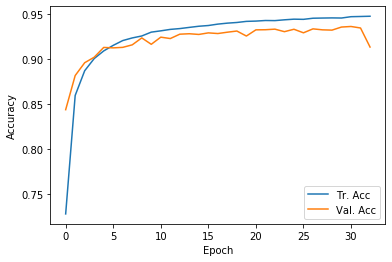

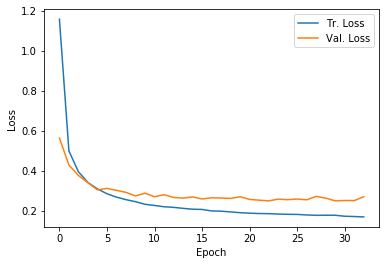

--- Test set evaluation ---
Loss              : 0.2608
Accuracy          : 0.9312
Balanced accuracy : 0.8132


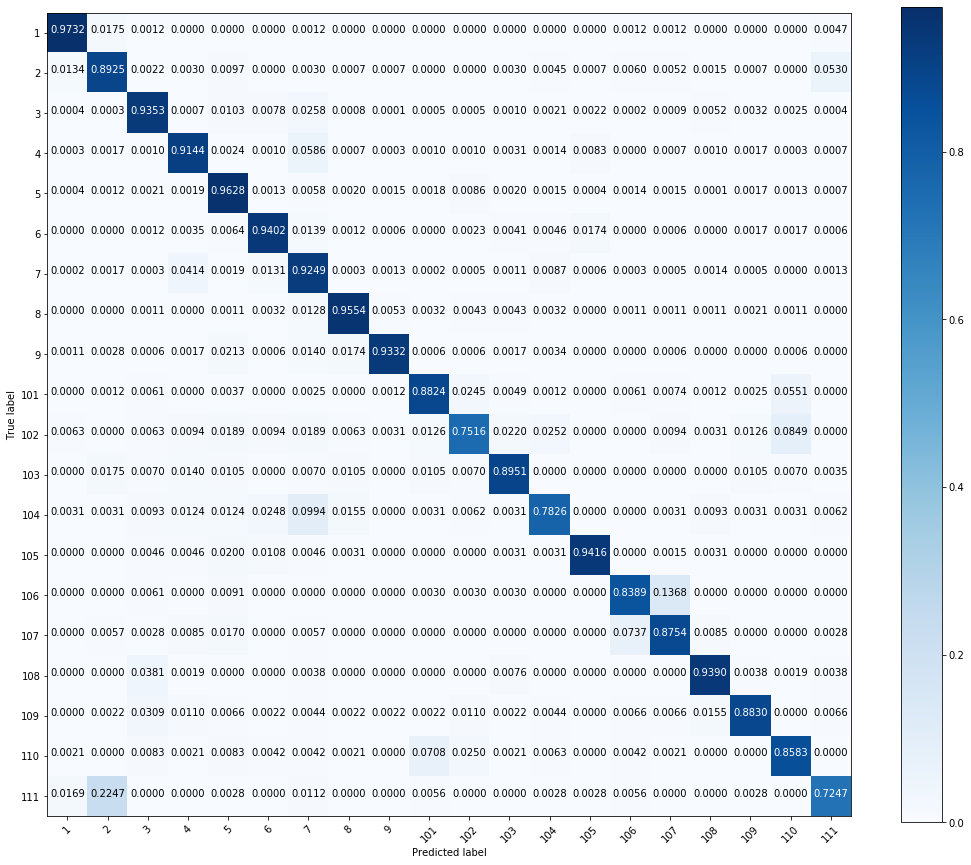

===== Model 13: filters = 64, kernel size = 3, pooling size = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 1022, 64)          256       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 1020, 64)          12352     
_________________________________________________________________
batch_normalization_14 (Batc (None, 1020, 64)          256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 340, 64)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 340, 64)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 21760)             0         
_________________________________________________________________
dense_27 (De

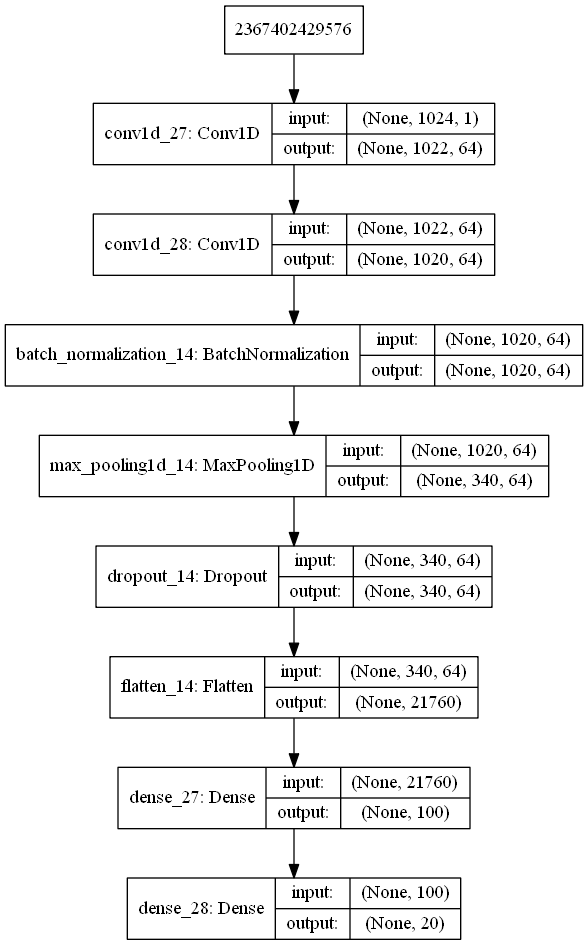

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 105s 587us/step - loss: 1.2407 - acc: 0.6810 - val_loss: 0.7188 - val_acc: 0.8042
Epoch 2/100
178346/178346 [==============================] - 103s 578us/step - loss: 0.6497 - acc: 0.8179 - val_loss: 0.5384 - val_acc: 0.8495
Epoch 3/100
178346/178346 [==============================] - 103s 578us/step - loss: 0.5164 - acc: 0.8527 - val_loss: 0.4477 - val_acc: 0.8721
Epoch 4/100
178346/178346 [==============================] - 103s 578us/step - loss: 0.4456 - acc: 0.8711 - val_loss: 0.3974 - val_acc: 0.8872
Epoch 5/100
178346/178346 [==============================] - 103s 578us/step - loss: 0.3928 - acc: 0.8851 - val_loss: 0.3628 - val_acc: 0.8962
Epoch 6/100
178346/178346 [==============================] - 105s 587us/step - loss: 0.3578 - acc: 0.8950 - val_loss: 0.3297 - val_acc: 0.9067
Epoch 7/100
178346/178346 [==============================] - 105s 587us/step - loss: 0.3292

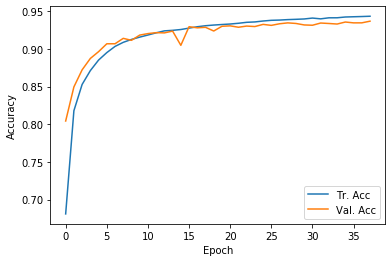

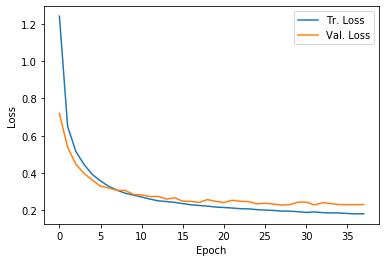

--- Test set evaluation ---
Loss              : 0.2434
Accuracy          : 0.9315
Balanced accuracy : 0.8124


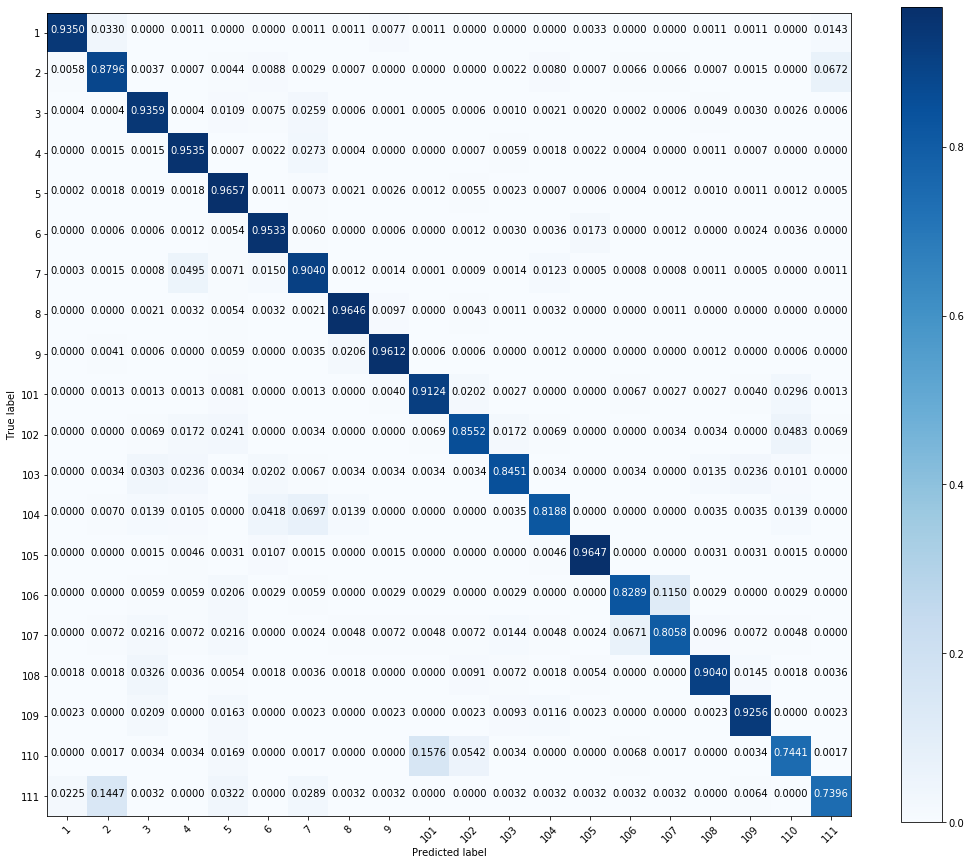

===== Model 14: filters = 64, kernel size = 3, pooling size = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 1022, 64)          256       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1020, 64)          12352     
_________________________________________________________________
batch_normalization_15 (Batc (None, 1020, 64)          256       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 255, 64)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 255, 64)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 16320)             0         
_________________________________________________________________
dense_29 (De

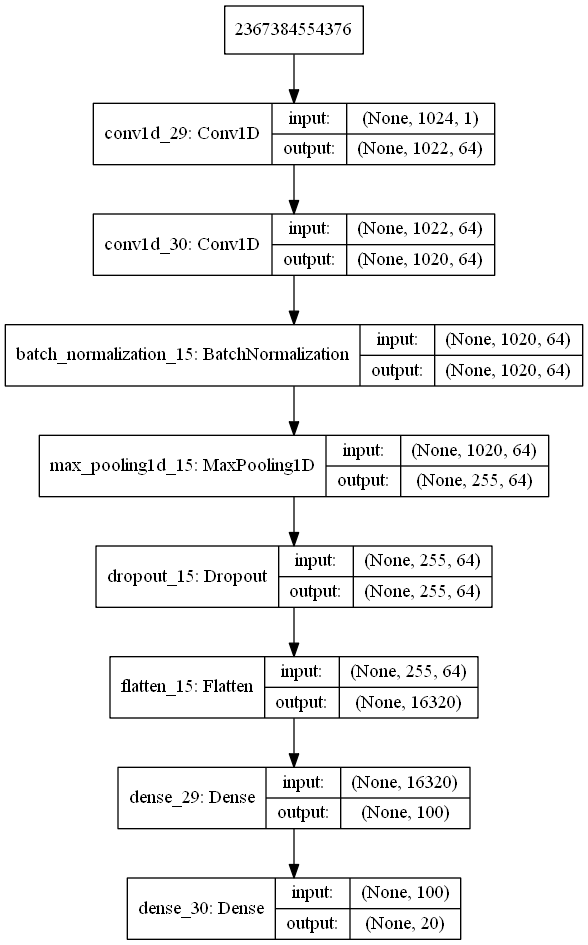

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 103s 579us/step - loss: 1.4298 - acc: 0.6283 - val_loss: 0.9422 - val_acc: 0.7332
Epoch 2/100
178346/178346 [==============================] - 102s 570us/step - loss: 0.8233 - acc: 0.7699 - val_loss: 0.7237 - val_acc: 0.8030
Epoch 3/100
178346/178346 [==============================] - 102s 569us/step - loss: 0.6642 - acc: 0.8124 - val_loss: 0.5986 - val_acc: 0.8363
Epoch 4/100
178346/178346 [==============================] - 102s 570us/step - loss: 0.5770 - acc: 0.8351 - val_loss: 0.5348 - val_acc: 0.8547
Epoch 5/100
178346/178346 [==============================] - 101s 569us/step - loss: 0.5157 - acc: 0.8537 - val_loss: 0.4762 - val_acc: 0.8687
Epoch 6/100
178346/178346 [==============================] - 102s 569us/step - loss: 0.4743 - acc: 0.8639 - val_loss: 0.4523 - val_acc: 0.8747
Epoch 7/100
178346/178346 [==============================] - 102s 570us/step - loss: 0.4419

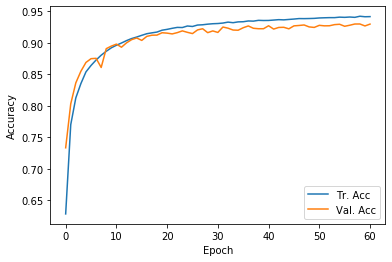

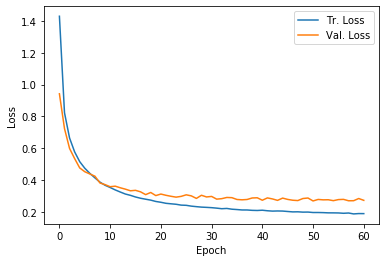

--- Test set evaluation ---
Loss              : 0.2792
Accuracy          : 0.9259
Balanced accuracy : 0.7977


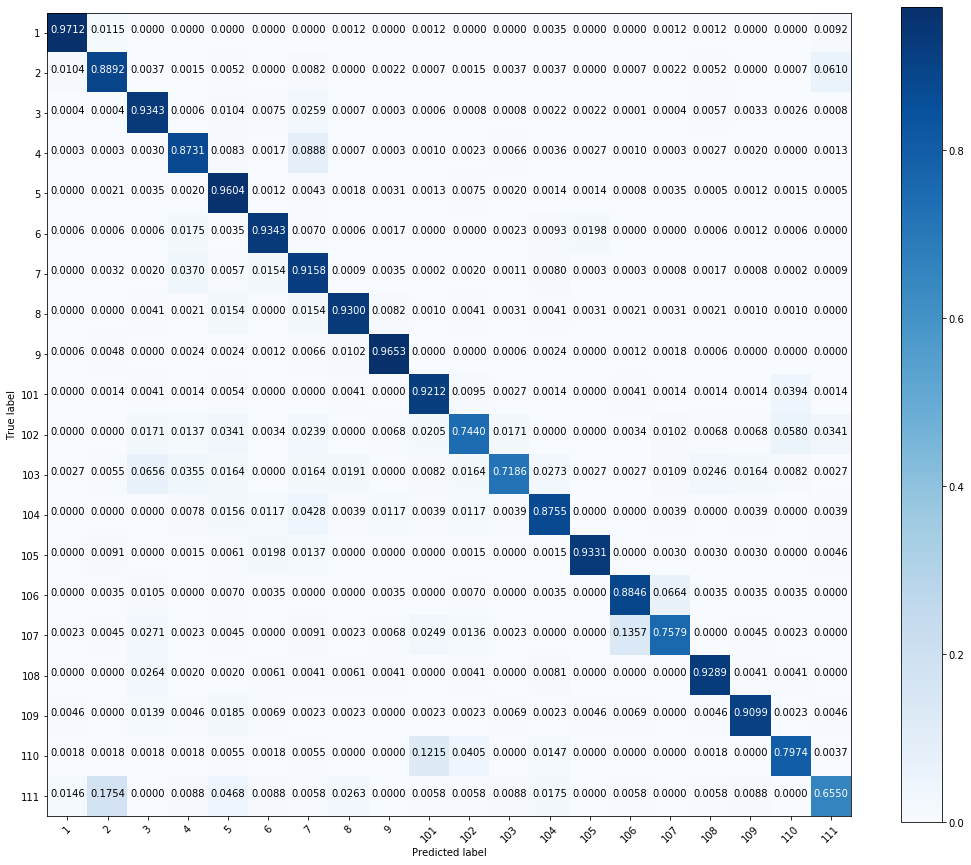

===== Model 15: filters = 64, kernel size = 4, pooling size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 1021, 64)          320       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1018, 64)          16448     
_________________________________________________________________
batch_normalization_16 (Batc (None, 1018, 64)          256       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 509, 64)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 509, 64)           0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 32576)             0         
_________________________________________________________________
dense_31 (De

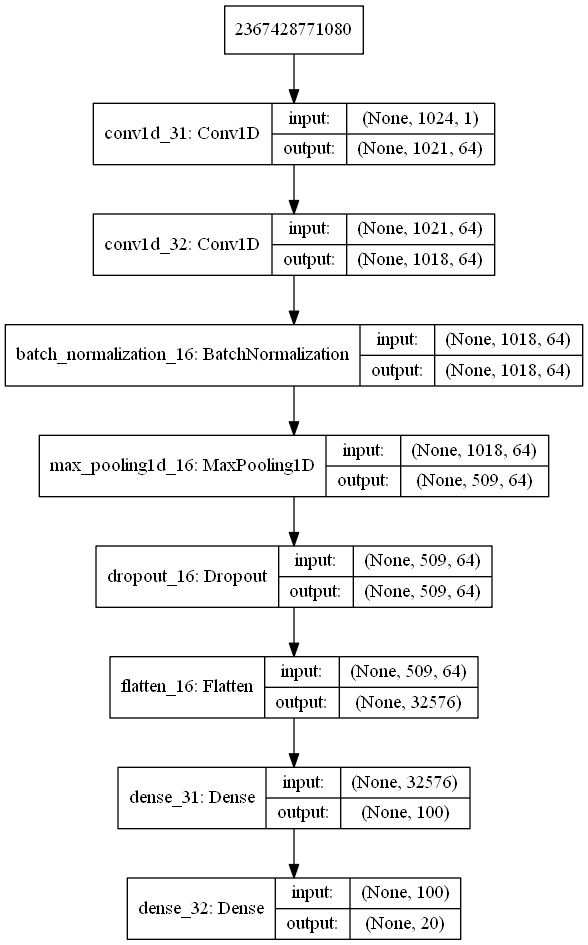

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 117s 658us/step - loss: 1.1453 - acc: 0.7104 - val_loss: 0.6313 - val_acc: 0.8294
Epoch 2/100
178346/178346 [==============================] - 116s 648us/step - loss: 0.5660 - acc: 0.8411 - val_loss: 0.4792 - val_acc: 0.8621
Epoch 3/100
178346/178346 [==============================] - 115s 647us/step - loss: 0.4515 - acc: 0.8707 - val_loss: 0.4101 - val_acc: 0.8786
Epoch 4/100
178346/178346 [==============================] - 115s 647us/step - loss: 0.3953 - acc: 0.8856 - val_loss: 0.3683 - val_acc: 0.8944
Epoch 5/100
178346/178346 [==============================] - 115s 648us/step - loss: 0.3590 - acc: 0.8944 - val_loss: 0.3706 - val_acc: 0.8962
Epoch 6/100
178346/178346 [==============================] - 116s 648us/step - loss: 0.3307 - acc: 0.9023 - val_loss: 0.3416 - val_acc: 0.9015
Epoch 7/100
178346/178346 [==============================] - 116s 648us/step - loss: 0.3100

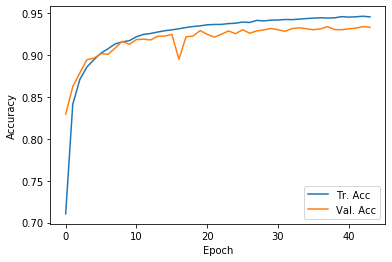

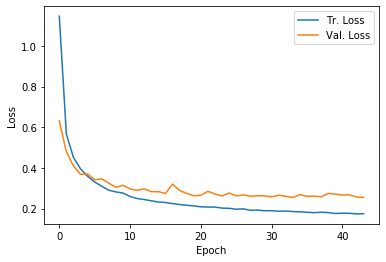

--- Test set evaluation ---
Loss              : 0.2728
Accuracy          : 0.9296
Balanced accuracy : 0.8097


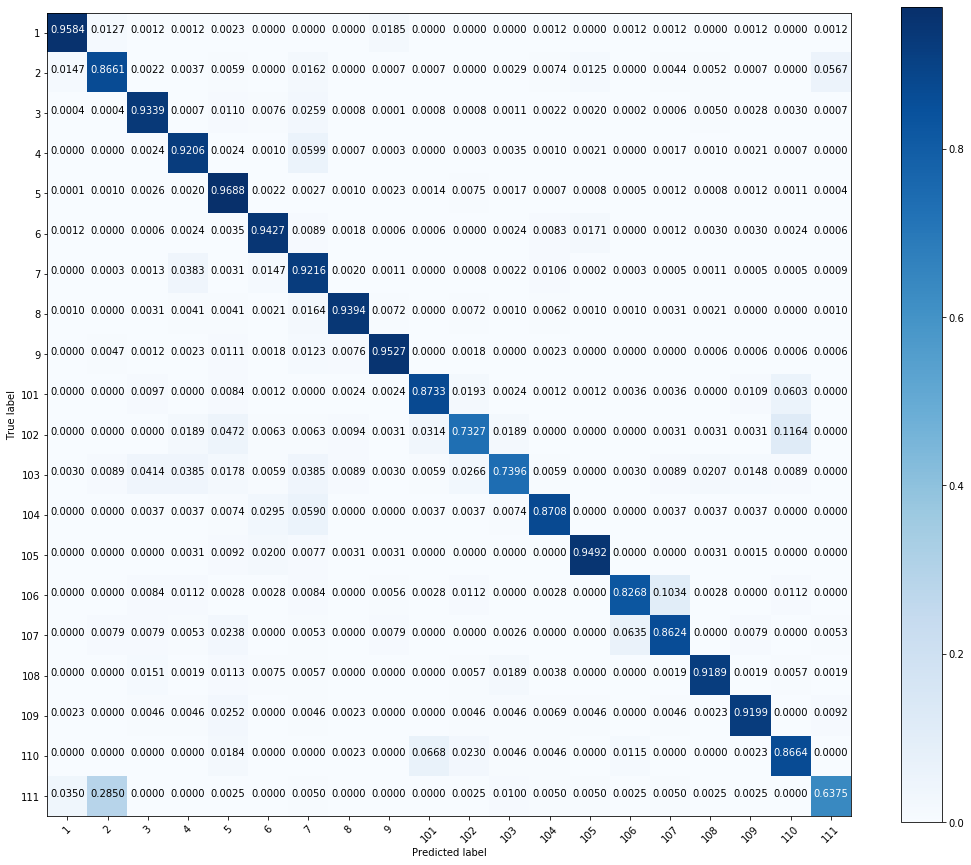

===== Model 16: filters = 64, kernel size = 4, pooling size = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 1021, 64)          320       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 1018, 64)          16448     
_________________________________________________________________
batch_normalization_17 (Batc (None, 1018, 64)          256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 339, 64)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 339, 64)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 21696)             0         
_________________________________________________________________
dense_33 (De

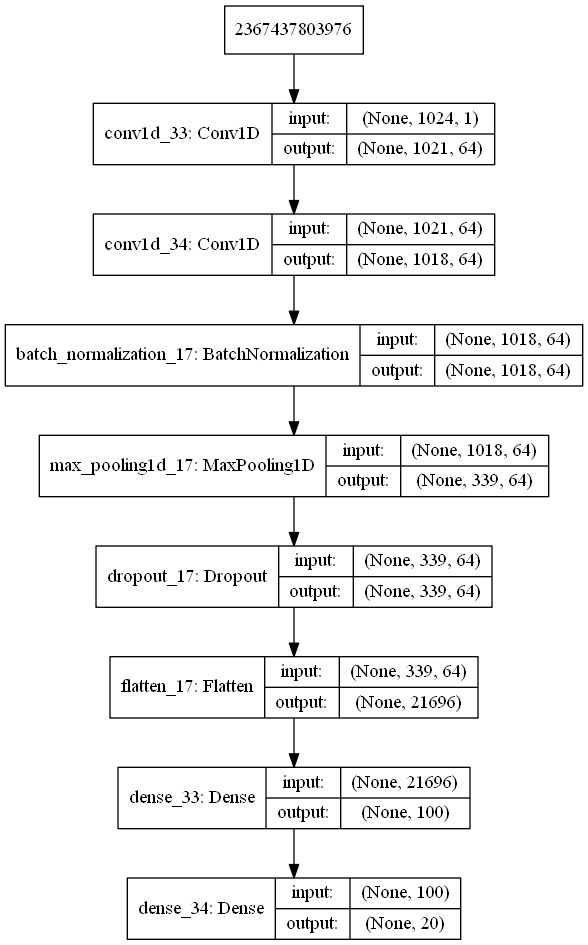

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 111s 621us/step - loss: 1.2739 - acc: 0.6858 - val_loss: 0.6611 - val_acc: 0.8203
Epoch 2/100
178346/178346 [==============================] - 109s 611us/step - loss: 0.5988 - acc: 0.8302 - val_loss: 0.4928 - val_acc: 0.8600
Epoch 3/100
178346/178346 [==============================] - 109s 611us/step - loss: 0.4702 - acc: 0.8647 - val_loss: 0.3936 - val_acc: 0.8893
Epoch 4/100
178346/178346 [==============================] - 109s 610us/step - loss: 0.4029 - acc: 0.8829 - val_loss: 0.3651 - val_acc: 0.8946
Epoch 5/100
178346/178346 [==============================] - 109s 611us/step - loss: 0.3599 - acc: 0.8947 - val_loss: 0.3356 - val_acc: 0.8998
Epoch 6/100
178346/178346 [==============================] - 109s 610us/step - loss: 0.3311 - acc: 0.9016 - val_loss: 0.3412 - val_acc: 0.8987
Epoch 7/100
178346/178346 [==============================] - 109s 611us/step - loss: 0.3065

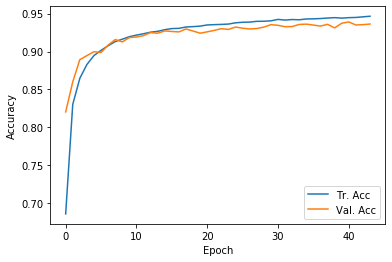

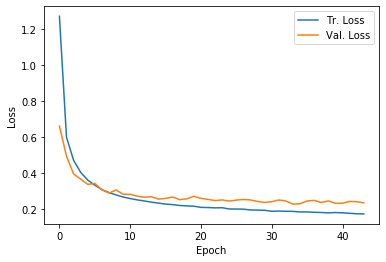

--- Test set evaluation ---
Loss              : 0.2423
Accuracy          : 0.9337
Balanced accuracy : 0.8215


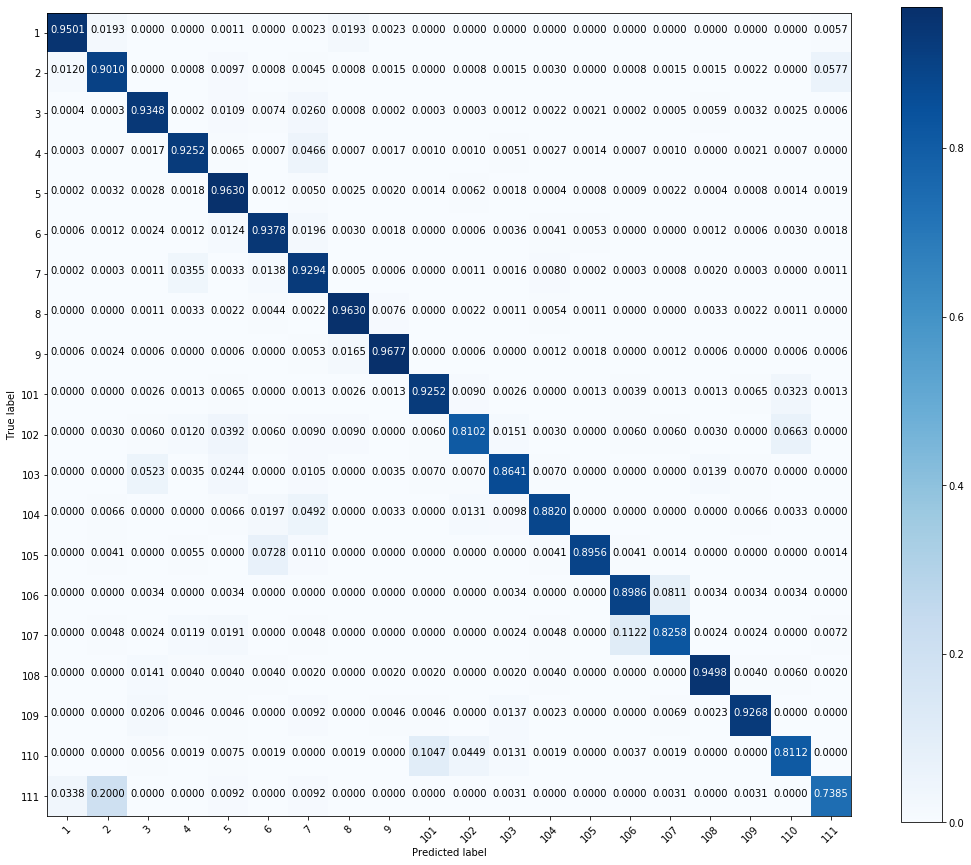

===== Model 17: filters = 64, kernel size = 4, pooling size = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 1021, 64)          320       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 1018, 64)          16448     
_________________________________________________________________
batch_normalization_18 (Batc (None, 1018, 64)          256       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 254, 64)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 254, 64)           0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 16256)             0         
_________________________________________________________________
dense_35 (De

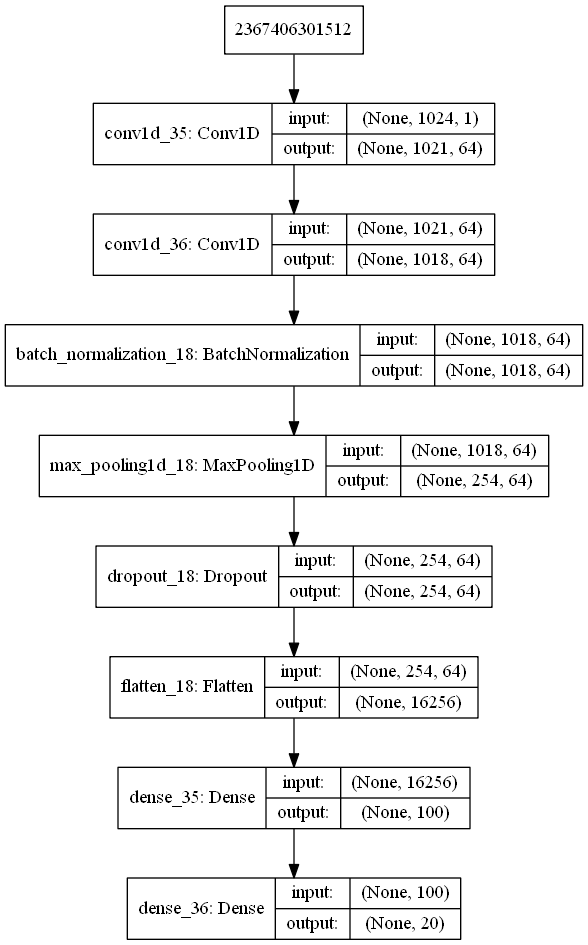

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 108s 607us/step - loss: 1.4297 - acc: 0.6389 - val_loss: 0.9138 - val_acc: 0.7522
Epoch 2/100
178346/178346 [==============================] - 107s 597us/step - loss: 0.7830 - acc: 0.7820 - val_loss: 0.7160 - val_acc: 0.7799
Epoch 3/100
178346/178346 [==============================] - 106s 595us/step - loss: 0.6203 - acc: 0.8255 - val_loss: 0.5503 - val_acc: 0.8510
Epoch 4/100
178346/178346 [==============================] - 106s 596us/step - loss: 0.5305 - acc: 0.8500 - val_loss: 0.4805 - val_acc: 0.8682
Epoch 5/100
178346/178346 [==============================] - 106s 596us/step - loss: 0.4815 - acc: 0.8636 - val_loss: 0.4405 - val_acc: 0.8760
Epoch 6/100
178346/178346 [==============================] - 106s 596us/step - loss: 0.4523 - acc: 0.8717 - val_loss: 0.4201 - val_acc: 0.8846
Epoch 7/100
178346/178346 [==============================] - 106s 596us/step - loss: 0.4238

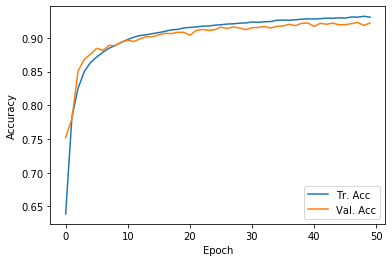

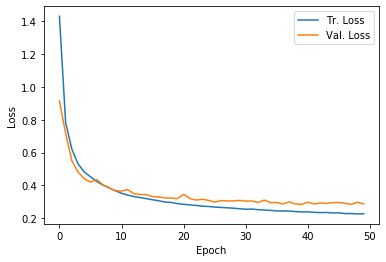

--- Test set evaluation ---
Loss              : 0.3001
Accuracy          : 0.9199
Balanced accuracy : 0.7705


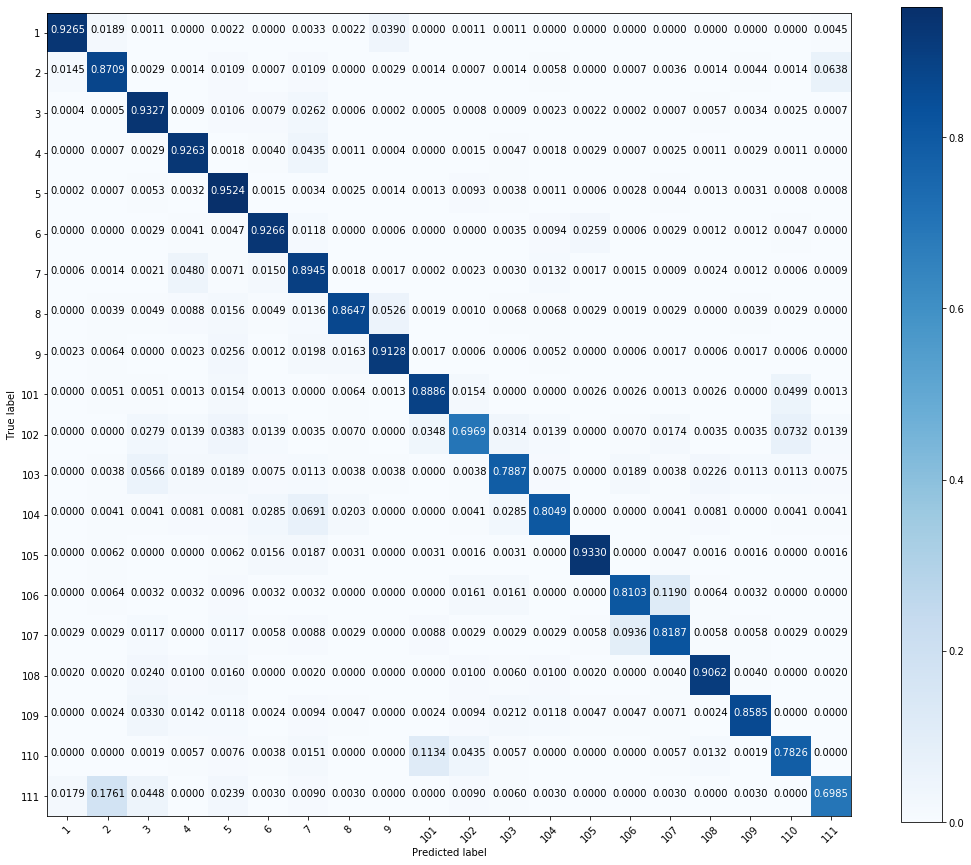

Elapsed time: 77103.33 seconds (21.42 hours)


In [11]:
if TRAIN_ALL:
    # how long does this take?
    start_time = time.time()

    # gather training stats
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)

    stats_path = os.path.join(stats_dir, "training_stats.csv")
    stats_file = open(stats_path, "w+")
    stats_file.write(
        "Model,Parameters,Training Epoch,Training Loss,Training Accuracy,Test Loss,Test Accuracy,Balanced Test Accuracy\n")

    # gather model stats
    models_dir = os.path.join(os.getcwd(), "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    models_path = os.path.join(models_dir, "models.csv")
    models_file = open(models_path, "w+")
    models_file.write("Model,Filters,Kernel Size,Pooling Size\n")

    # stop early if possible
    callbacks = [EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    )]

    # this'll take a while
    count = 0
    for n in num_filters:
        for k in kernel_size:
            for p in pool_size:
                print("{}\n{} Model {}: filters = {}, kernel size = {}, pooling size = {}\n{}".format(
                    "=" * 100, "=" * 5, count, n, k, p, "=" * 100))

                # filepaths
                model_name = "model_{}".format(count)

                # build and show model
                model = build_model(n, k, p, model_name)

                # we'll need these these
                y_ints = [y.argmax() for y in all_train_y]
                class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)

                # train model
                history = model.fit(
                    all_train_x, all_train_y,
                    validation_data = (all_val_x, all_val_y),
                    class_weight = class_weights,
                    batch_size = 512,
                    epochs = 100,
                    shuffle = True,
                    verbose = 1,
                    callbacks = callbacks)

                # save trained model
                save_model(model, model_name)

                # show the graph history
                graph_history(history, model_name, validation_data=True)

                # evaluate the model
                evaluation = model.evaluate(all_test_x, all_test_y, verbose=0)

                print("--- Test set evaluation ---")
                print("Loss              : {:.4f}".format(evaluation[0]))
                print("Accuracy          : {:.4f}".format(evaluation[1]))

                # predict the test set and save the labels
                actual_labels = np.argmax(all_test_y, axis=1)
                predicted_labels = np.argmax(model.predict(all_test_x), axis=1)
                balanced_acc = balanced_accuracy_score(actual_labels, predicted_labels)

                print("Balanced accuracy : {:.4f}".format(balanced_acc))

                # revert to the original vehicle IDs
                actual_labels = [old_labels[i] for i in actual_labels]
                predicted_labels = [old_labels[i] for i in predicted_labels]

                # generate, save, and display confusion matrix
                cm = confusion_matrix(predicted_labels, actual_labels)
                plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

                # get stats
                params = model.count_params()
                best_epoch = np.argmin(history.history["val_loss"])
                best_loss = history.history["val_loss"][best_epoch]
                best_acc = history.history["val_acc"][best_epoch]

                # save stats
                stats = [count, params, best_epoch + 1, best_loss, best_acc, evaluation[0], evaluation[1], balanced_acc]
                stats_file.write(",".join([str(s) for s in stats]) + "\n")

                # save model metadata
                model_metadata = [count, n, k, p]
                models_file.write(",".join([str(d) for d in model_metadata]) + "\n")

                # next model
                count += 1

    stats_file.close()
    models_file.close()

    elapsed_time = time.time() - start_time
    print("Elapsed time: {:.2f} seconds ({:.2f} hours)".format(elapsed_time, elapsed_time / 3600.))

## Train and test the best model

Model           10
Filters         64
Kernel Size      2
Pooling Size     3
Name: 10, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 1023, 64)          192       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1022, 64)          8256      
_________________________________________________________________
batch_normalization_11 (Batc (None, 1022, 64)          256       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 340, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 340, 64)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 21760)             0         
___________________________________________

178346/178346 [==============================] - 102s 570us/step - loss: 0.2058 - acc: 0.9355 - val_loss: 0.2483 - val_acc: 0.9317
Epoch 48/100
178346/178346 [==============================] - 102s 570us/step - loss: 0.2055 - acc: 0.9353 - val_loss: 0.2437 - val_acc: 0.9323
Epoch 49/100
178346/178346 [==============================] - 102s 570us/step - loss: 0.2039 - acc: 0.9361 - val_loss: 0.2501 - val_acc: 0.9315
Epoch 50/100
178346/178346 [==============================] - 101s 569us/step - loss: 0.2016 - acc: 0.9369 - val_loss: 0.2472 - val_acc: 0.9305
Epoch 51/100
178346/178346 [==============================] - 101s 568us/step - loss: 0.2021 - acc: 0.9366 - val_loss: 0.2486 - val_acc: 0.9333
Epoch 52/100
178346/178346 [==============================] - 101s 567us/step - loss: 0.2003 - acc: 0.9373 - val_loss: 0.2502 - val_acc: 0.9311
Epoch 53/100
178346/178346 [==============================] - 101s 568us/step - loss: 0.1997 - acc: 0.9374 - val_loss: 0.2424 - val_acc: 0.9322
Epoch

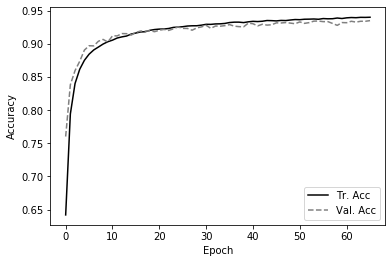

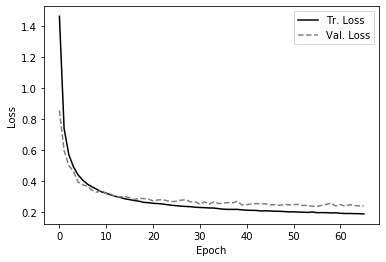

In [20]:
if TRAIN_BEST:
    # stop early if possible
    callbacks = [EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    )]
    
    for dataset in ["all"]:
        # best model
        training_stats = pd.read_csv(os.path.join(os.getcwd(), "stats", "training_stats.csv"))
        best_model = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Model"])
        best_epoch = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Training Epoch"])
        
        # model parameters
        model_params = pd.read_csv(os.path.join(os.getcwd(), "models", "models.csv"))
        best_model = model_params.iloc[best_model]
        print(best_model)

        # filepaths
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"

        # build and show model
        model = build_model(int(best_model["Filters"]), int(best_model["Kernel Size"]), int(best_model["Pooling Size"]), model_name)

        # we'll need these
        train_x = all_train_x if dataset == "all" else balanced_train_x
        train_y = all_train_y if dataset == "all" else balanced_train_y
        val_x = all_val_x if dataset == "all" else balanced_val_x
        val_y = all_val_y if dataset == "all" else balanced_val_y
        test_x = all_test_x if dataset == "all" else balanced_test_x
        test_y = all_test_y if dataset == "all" else balanced_test_y

        # and these
        y_ints = [y.argmax() for y in all_train_y]
        class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)
        class_weights = class_weights if dataset == "all" else None

        # train model
        history = model.fit(
            train_x, train_y,
            validation_data = (val_x, val_y),
            class_weight = class_weights,
            batch_size = 512,
            epochs = 100,
            shuffle = True,
            verbose = 1,
            callbacks = callbacks)
        
#         history = model.fit(
#             np.concatenate((train_x, val_x)), np.concatenate((train_y, val_y)),
#             class_weight = class_weights,
#             batch_size = 512,
#             epochs = best_epoch,
#             shuffle = True,
#             verbose = 1)

#         # save trained model
#         save_model(model, model_name)

        # show the graph history
        graph_history(history, model_name, validation_data=True)

#         # evaluate the model
#         evaluation = model.evaluate(test_x, test_y, verbose=0)

#         print("--- Test set evaluation ---")
#         print("Loss              : {:.4f}".format(evaluation[0]))
#         print("Accuracy          : {:.4f}".format(evaluation[1]))

#         # predict the test set and save the labels
#         actual_labels = np.argmax(test_y, axis=1)
#         predicted_labels = np.argmax(model.predict(test_x), axis=1)

#         print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

#         # revert to the original vehicle IDs
#         actual_labels = [old_labels[i] for i in actual_labels]
#         predicted_labels = [old_labels[i] for i in predicted_labels]

#         # generate, save, and display confusion matrix
#         cm = confusion_matrix(predicted_labels, actual_labels)
#         plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

In [10]:
if TRAIN_BEST:
    for dataset in ["all", "balanced"]:
        # best model
        training_stats = pd.read_csv(os.path.join(os.getcwd(), "stats", "training_stats.csv"))
        best_model = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Model"])
        best_epoch = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Training Epoch"])
        
        # model parameters
        model_params = pd.read_csv(os.path.join(os.getcwd(), "models", "models.csv"))
        best_model = model_params.iloc[best_model]
        print(best_model)

        # filepaths
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"

        # build and show model
        model = build_model(int(best_model["Filters"]), int(best_model["Kernel Size"]), int(best_model["Pooling Size"]), model_name)

        # we'll need these
        train_x = all_train_x if dataset == "all" else balanced_train_x
        train_y = all_train_y if dataset == "all" else balanced_train_y
        val_x = all_val_x if dataset == "all" else balanced_val_x
        val_y = all_val_y if dataset == "all" else balanced_val_y
        test_x = all_test_x if dataset == "all" else balanced_test_x
        test_y = all_test_y if dataset == "all" else balanced_test_y

        # and these
        y_ints = [y.argmax() for y in all_train_y]
        class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)
        class_weights = class_weights if dataset == "all" else None

        # train model
        history = model.fit(
            np.concatenate((train_x, val_x)), np.concatenate((train_y, val_y)),
            class_weight = class_weights,
            batch_size = 512,
            epochs = best_epoch,
            shuffle = True,
            verbose = 1)

        # save trained model
        save_model(model, model_name)

        # show the graph history
        graph_history(history, model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation ---")
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

W0909 09:20:58.526427  6596 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 09:20:58.550362  6596 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:519: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 09:20:58.554352  6596 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:4140: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model           10
Filters         64
Kernel Size      2
Pooling Size     3
Name: 10, dtype: int64


W0909 09:20:58.710312  6596 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0909 09:20:58.733210  6596 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:3978: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0909 09:20:58.752161  6596 deprecation.py:506] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:3447: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0909 09:20:58.840672  6596 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1023, 64)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1022, 64)          8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1022, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 340, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 340, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21760)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2176100   
__________

W0909 09:21:00.925412  6596 deprecation.py:323] From C:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/46
  1536/237795 [..............................] - ETA: 21:20 - loss: 6.5822 - acc: 0.2520

KeyboardInterrupt: 

## Load and test the best model

In [2]:
if not TRAIN_BEST:
    for dataset in ["all", "balanced"]:
        # we'll need these
        test_x = all_test_x if dataset == "all" else balanced_test_x
        test_y = all_test_y if dataset == "all" else balanced_test_y

        # name the model
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"
        model = load_model(model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation ---")
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

NameError: name 'TRAIN_BEST' is not defined